In [ ]:
from pathlib import Path
import pandas as pd

DATA = Path("data/raw")
  # adjust if your notebook sits in notebooks/

hi_small_trans = pd.read_csv(DATA/"HI-Small_Trans.csv", engine="pyarrow")
hi_small_accts = pd.read_csv(DATA/"HI-Small_accounts.csv", engine="pyarrow")

print(hi_small_trans.shape, hi_small_accts.shape)
display(hi_small_trans.head(3))
display(hi_small_accts.head(3))

In [ ]:
from pathlib import Path

DATA = Path("data/raw")  # or ../data/raw if notebook is inside notebooks/
print("Path exists:", DATA.exists())
print("Files:", list(DATA.glob("*.csv")))


In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np

DATA = Path("data/raw")      # <-- if notebook is under notebooks/
SAVE = Path("data/interim")
SAVE.mkdir(parents=True, exist_ok=True)

print("DATA exists:", DATA.exists())
print("CSV files:", sorted([p.name for p in DATA.glob("*.csv")]))


In [ ]:
read_opts = dict(engine="pyarrow")

datasets = {
    "HI_Small_Trans": DATA/"HI-Small_Trans.csv",
    "HI_Small_Accts": DATA/"HI-Small_accounts.csv",
    "LI_Small_Trans": DATA/"LI-Small_Trans.csv",
    "LI_Small_Accts": DATA/"LI-Small_accounts.csv",
    "HI_Med_Trans":   DATA/"HI-Medium_Trans.csv",
    "HI_Med_Accts":   DATA/"HI-Medium_accounts.csv",
    "LI_Med_Trans":   DATA/"LI-Medium_Trans.csv",
    "LI_Med_Accts":   DATA/"LI-Medium_accounts.csv",
}

dfs = {}
for name, path in datasets.items():
    print(f"Loading {name} ...")
    df = pd.read_csv(path, **read_opts)
    dfs[name] = df
    print(f"  → {df.shape[0]:,} rows × {df.shape[1]} cols")
print("✅ loaded all")


In [ ]:
import pandas as pd
from pathlib import Path

DATA = Path("data/raw")
SAVE = Path("data/interim")
SAVE.mkdir(parents=True, exist_ok=True)

def csv_to_parquet_chunked(SRC, DST, chunksize=1_000_000, usecols=None, parse_dates=None):
    """Stream a big CSV to a single Parquet file with minimal memory use."""
    first = True
    pq_parts = []
    for i, chunk in enumerate(pd.read_csv(SRC, chunksize=chunksize, usecols=usecols,
                                          parse_dates=parse_dates, low_memory=True)):
        # optional downcasting (shrinks memory a lot)
        for col in chunk.select_dtypes(include="float").columns:
            chunk[col] = pd.to_numeric(chunk[col], downcast="float")
        for col in chunk.select_dtypes(include="integer").columns:
            chunk[col] = pd.to_numeric(chunk[col], downcast="integer")

        part_path = SAVE / f"{DST.stem}_part{i:03d}.parquet"
        chunk.to_parquet(part_path, index=False)   # write part
        pq_parts.append(part_path)

    # stitch parts into one (optional – or keep partitioned)
    # If you’re fine with multiple parts, skip this stitching step.
    if len(pq_parts) > 1:
        import pyarrow as pa, pyarrow.parquet as pq
        tables = [pq.read_table(p) for p in pq_parts]
        table = pa.concat_tables(tables)
        pq.write_table(table, DST)
        for p in pq_parts: p.unlink()  # remove parts
    elif len(pq_parts) == 1:
        pq_parts[0].rename(DST)

# === Choose columns you actually need (speeds up and reduces RAM) ===
USECOLS_TRANS = None  # or e.g. ["Timestamp","From Bank","From Account","To Bank","To Account","Amount Paid"]
USECOLS_ACCTS = None  # or e.g. ["Account ID","Entity ID","Entity Name","Bank Name"]

# HI-Medium
csv_to_parquet_chunked(
    SRC=DATA/"HI-Medium_Trans.csv",
    DST=SAVE/"HI_Medium_Trans.parquet",
    chunksize=1_000_000,
    usecols=USECOLS_TRANS,
    parse_dates=None  # set to your timestamp column if you already know it
)
csv_to_parquet_chunked(
    SRC=DATA/"HI-Medium_accounts.csv",
    DST=SAVE/"HI_Medium_accounts.parquet",
    chunksize=500_000,
    usecols=USECOLS_ACCTS
)

# LI-Medium (repeat when ready)
# csv_to_parquet_chunked(DATA/"LI-Medium_Trans.csv", SAVE/"LI_Medium_Trans.parquet", chunksize=1_000_000, usecols=USECOLS_TRANS)
# csv_to_parquet_chunked(DATA/"LI-Medium_accounts.csv", SAVE/"LI_Medium_accounts.parquet", chunksize=500_000, usecols=USECOLS_ACCTS)


In [ ]:
hi_med_t = pd.read_parquet("../data/interim/HI_Medium_Trans.parquet")
hi_med_a = pd.read_parquet("../data/interim/HI_Medium_accounts.parquet")
print(hi_med_t.shape, hi_med_a.shape)


In [ ]:
from pathlib import Path

INT = Path("../data/interim")
print("Exists:", INT.exists())
print("Contents:", [f.name for f in INT.glob("*")])


In [ ]:
import pandas as pd
from pathlib import Path
import pyarrow as pa, pyarrow.parquet as pq

DATA = Path("data/raw")
SAVE = Path("data/interim")
SAVE.mkdir(parents=True, exist_ok=True)

def csv_to_parquet_chunked(SRC, DST, chunksize=1_000_000):
    pq_parts = []
    for i, chunk in enumerate(pd.read_csv(SRC, chunksize=chunksize, low_memory=True)):
        print(f"Chunk {i+1} ...", end=" ")
        part_path = SAVE / f"{DST.stem}_part{i:03d}.parquet"
        chunk.to_parquet(part_path, index=False)
        pq_parts.append(part_path)
        print("saved")

    if len(pq_parts) > 1:
        tables = [pq.read_table(p) for p in pq_parts]
        pq.write_table(pa.concat_tables(tables), DST)
        for p in pq_parts: p.unlink()
    else:
        pq_parts[0].rename(DST)
    print("✅ Done:", DST.name)

# Convert only HI-Medium
csv_to_parquet_chunked(DATA/"HI-Medium_Trans.csv", SAVE/"HI_Medium_Trans.parquet")
csv_to_parquet_chunked(DATA/"HI-Medium_accounts.csv", SAVE/"HI_Medium_accounts.parquet")


In [ ]:
print([f.name for f in Path("../data/interim").glob("*.parquet")])


In [ ]:
from pathlib import Path
print([f.name for f in Path("data/interim").glob("*.parquet")])


In [ ]:
hi_med_t = pd.read_parquet("data/interim/HI_Medium_Trans.parquet")
hi_med_a = pd.read_parquet("data/interim/HI_Medium_accounts.parquet")
print(hi_med_t.shape, hi_med_a.shape)


In [ ]:
def quick_report(df: pd.DataFrame, name: str):
    print(f"\n=== {name} ===")
    print("shape:", df.shape)
    print("memory (MB):", round(df.memory_usage(deep=True).sum()/1e6, 2))
    print("columns:", list(df.columns))
    miss = df.isna().mean().sort_values(ascending=False)
    print("missing ratio (top 10):")
    display(miss.head(10))
    display(df.head(3))

for k in ["HI_Small_Trans","HI_Small_Accts","LI_Small_Trans","LI_Small_Accts"]:
    quick_report(dfs[k], k)


In [ ]:
hi_med_t
hi_med_a


In [ ]:
def quick_report(df: pd.DataFrame, name: str):
    print(f"\n=== {name} ===")
    print("shape:", df.shape)
    print("memory (MB):", round(df.memory_usage(deep=True).sum()/1e6, 2))
    print("columns:", list(df.columns))
    miss = df.isna().mean().sort_values(ascending=False)
    print("missing ratio (top 10):")
    display(miss.head(10))
    display(df.head(3))

# Run quick reports for your loaded Medium sets
quick_report(hi_med_t, "HI-Medium Transactions")
quick_report(hi_med_a, "HI-Medium Accounts")


In [ ]:
def detect_columns(df):
    cols = df.columns
    candidates = {
        "tx_id": [c for c in cols if "trans" in c.lower() and "id" in c.lower()] + \
                 [c for c in cols if c.lower() in {"txid","tx_id","id"}],
        "acct_id": [c for c in cols if ("acct" in c.lower() or "account" in c.lower()) and "id" in c.lower()],
        "time": [c for c in cols if ("time" in c.lower()) or ("date" in c.lower())],
        "amount": [c for c in cols if ("amount" in c.lower()) or (c.lower() in {"amt","value","transactionamount"})],
        "label": [c for c in cols if c.lower() in {"is_illicit","isfraud","fraud","label","y","target"}],
    }
    return {k: v[:3] for k,v in candidates.items()}  # show top few

for k in ["HI_Small_Trans","HI_Small_Accts"]:
    print(k, detect_columns(dfs[k]))


In [ ]:
from IPython.display import display
import pandas as pd

# Quick report helper
def quick_report(df: pd.DataFrame, name: str):
    print(f"\n=== {name} ===")
    print("shape:", df.shape)
    print("memory (MB):", round(df.memory_usage(deep=True).sum()/1e6, 2))
    print("columns:", list(df.columns))
    miss = df.isna().mean().sort_values(ascending=False)
    print("missing ratio (top 10):")
    display(miss.head(10))
    display(df.head(3))


# --- Reload all four pairs if needed ---
# (Skip this section if they're already loaded in memory)
DATA = Path("data/raw")
hi_small_trans = pd.read_csv(DATA/"HI-Small_Trans.csv", engine="pyarrow")
hi_small_accts = pd.read_csv(DATA/"HI-Small_accounts.csv", engine="pyarrow")
li_small_trans = pd.read_csv(DATA/"LI-Small_Trans.csv", engine="pyarrow")
li_small_accts = pd.read_csv(DATA/"LI-Small_accounts.csv", engine="pyarrow")

hi_med_t = pd.read_parquet("data/interim/HI_Medium_Trans.parquet")
hi_med_a = pd.read_parquet("data/interim/HI_Medium_accounts.parquet")
# (If you later convert LI-Medium, you can add them too)


# --- Run quick reports for all four ---
quick_report(hi_small_trans, "HI-Small Transactions")
quick_report(hi_small_accts, "HI-Small Accounts")
quick_report(li_small_trans, "LI-Small Transactions")
quick_report(li_small_accts, "LI-Small Accounts")
quick_report(hi_med_t, "HI-Medium Transactions")
quick_report(hi_med_a, "HI-Medium Accounts")


In [ ]:
def detect_columns(df):
    cols = df.columns
    candidates = {
        "tx_id": [c for c in cols if "trans" in c.lower() and "id" in c.lower()] + \
                 [c for c in cols if c.lower() in {"txid","tx_id","id"}],
        "acct_id": [c for c in cols if ("acct" in c.lower() or "account" in c.lower()) and "id" in c.lower()],
        "time": [c for c in cols if ("time" in c.lower()) or ("date" in c.lower())],
        "amount": [c for c in cols if ("amount" in c.lower()) or (c.lower() in {"amt","value","transactionamount"})],
        "label": [c for c in cols if c.lower() in {"is_illicit","isfraud","fraud","label","y","target"}],
    }
    return {k: v[:3] for k,v in candidates.items()}

# Run on one sample to check naming conventions
print("HI-Small Transactions:", detect_columns(hi_small_trans))
print("HI-Small Accounts:", detect_columns(hi_small_accts))
print("LI-Small Transactions:", detect_columns(li_small_trans))
print("LI-Small Accounts:", detect_columns(li_small_accts))
print("HI-Medium Transactions:", detect_columns(hi_med_t))
print("HI-Medium Accounts:", detect_columns(hi_med_a))


In [ ]:
from IPython.display import display
import pandas as pd

# Define helper function
def quick_report(df: pd.DataFrame, name: str):
    print(f"\n=== {name} ===")
    print("Shape:", df.shape)
    print("Memory (MB):", round(df.memory_usage(deep=True).sum() / 1_000_000, 2))
    print("Columns:", list(df.columns))
    
    # Missing value ratios
    miss = df.isna().mean().sort_values(ascending=False)
    print("Missing ratio (top 10):")
    display(miss.head(10))
    
    # Show a quick preview
    display(df.head(3))


# --- Reload if needed (skip if already loaded) ---
from pathlib import Path
DATA = Path("data/raw")
INT = Path("data/interim")

# Uncomment if you need to reload
# hi_small_trans = pd.read_csv(DATA/"HI-Small_Trans.csv", engine="pyarrow")
# hi_small_accts = pd.read_csv(DATA/"HI-Small_accounts.csv", engine="pyarrow")
# li_small_trans = pd.read_csv(DATA/"LI-Small_Trans.csv", engine="pyarrow")
# li_small_accts = pd.read_csv(DATA/"LI-Small_accounts.csv", engine="pyarrow")
# hi_med_t = pd.read_parquet(INT/"HI_Medium_Trans.parquet")
# hi_med_a = pd.read_parquet(INT/"HI_Medium_accounts.parquet")

# --- Run quick reports for all ---
quick_report(hi_small_trans, "HI-Small Transactions")
quick_report(hi_small_accts, "HI-Small Accounts")
quick_report(li_small_trans, "LI-Small Transactions")
quick_report(li_small_accts, "LI-Small Accounts")
quick_report(hi_med_t, "HI-Medium Transactions")
quick_report(hi_med_a, "HI-Medium Accounts")


In [ ]:
def detect_columns(df):
    cols = df.columns
    candidates = {
        "tx_id": [c for c in cols if "trans" in c.lower() and "id" in c.lower()] + \
                 [c for c in cols if c.lower() in {"txid","tx_id","id"}],
        "acct_id": [c for c in cols if ("acct" in c.lower() or "account" in c.lower()) and "id" in c.lower()],
        "time": [c for c in cols if ("time" in c.lower()) or ("date" in c.lower())],
        "amount": [c for c in cols if ("amount" in c.lower()) or (c.lower() in {"amt","value","transactionamount"})],
        "label": [c for c in cols if c.lower() in {"is_illicit","isfraud","fraud","label","y","target"}],
    }
    return {k: v[:3] for k,v in candidates.items()}

# Run on one sample to check naming conventions
print("HI-Small Transactions:", detect_columns(hi_small_trans))
print("HI-Small Accounts:", detect_columns(hi_small_accts))
print("LI-Small Transactions:", detect_columns(li_small_trans))
print("LI-Small Accounts:", detect_columns(li_small_accts))
print("HI-Medium Transactions:", detect_columns(hi_med_t))
print("HI-Medium Accounts:", detect_columns(hi_med_a))

In [ ]:
TX_ID   = "Transaction ID"      # change if your output differs
ACCT_ID = "Account ID"          # e.g., "Acct_ID" or similar
DATECOL = "Timestamp"           # e.g., "Date", "Transaction Date"
AMOUNT  = "Amount Paid"         # e.g., "Amount", "Transaction Amount"
LABEL   = None                  # set automatically if a label column exists later


In [ ]:
hi_t = hi_small_trans.copy()

if DATECOL in hi_t.columns:
    hi_t[DATECOL] = pd.to_datetime(hi_t[DATECOL], errors="coerce")
if TX_ID in hi_t.columns:
    hi_t[TX_ID] = hi_t[TX_ID].astype(str)
if ACCT_ID in hi_t.columns:
    hi_t[ACCT_ID] = hi_t[ACCT_ID].astype(str)
if AMOUNT in hi_t.columns:
    hi_t[AMOUNT] = pd.to_numeric(hi_t[AMOUNT], errors="coerce")

# detect label if exists
for c in hi_t.columns:
    if c.lower() in {"is_illicit","isfraud","fraud","label","y","target"}:
        LABEL = c
        break

print("Using columns →", dict(TX_ID=TX_ID, ACCT_ID=ACCT_ID, DATECOL=DATECOL, AMOUNT=AMOUNT, LABEL=LABEL))
quick_report(hi_t, "HI-Small Trans (typed)")


In [ ]:
hi_a = hi_small_accts.copy()

if ACCT_ID in hi_a.columns:
    hi_a[ACCT_ID] = hi_a[ACCT_ID].astype(str)

# Prefix account columns to avoid name collisions
acct_pref = hi_a.add_prefix("acct_")
acct_pref = acct_pref.rename(columns={f"acct_{ACCT_ID}": ACCT_ID})

# Merge on account id
hi = hi_t.merge(acct_pref, on=ACCT_ID, how="left")
quick_report(hi, "HI-Small merged (Trans + Accounts)")


In [ ]:
print("HI-Small Transactions columns:")
print(list(hi_t.columns))

print("\nHI-Small Accounts columns:")
print(list(hi_a.columns))


In [ ]:
ACCT_ID = "Acct ID"         # change this to match your actual column name


In [ ]:
if ACCT_ID in hi_a.columns:
    hi_a[ACCT_ID] = hi_a[ACCT_ID].astype(str)

acct_pref = hi_a.add_prefix("acct_")
acct_pref = acct_pref.rename(columns={f"acct_{ACCT_ID}": ACCT_ID})

hi = hi_t.merge(acct_pref, on=ACCT_ID, how="left")
quick_report(hi, "HI-Small merged (Trans + Accounts)")


In [ ]:
print("HI-Small Transactions columns:")
print(list(hi_t.columns))

print("\nHI-Small Accounts columns:")
print(list(hi_a.columns))


In [ ]:
# Fix duplicate column names
hi_t.columns = ['Timestamp', 'From Bank', 'From Account', 'To Bank', 'To Account',
                'Amount Received', 'Receiving Currency', 'Amount Paid',
                'Payment Currency', 'Payment Format', 'Is Laundering']


In [ ]:
TX_ID   = None                   # not present in this dataset, we’ll create one
ACCT_ID = "From Account"         # matches sender
DATECOL = "Timestamp"
AMOUNT  = "Amount Paid"
LABEL   = "Is Laundering"


In [ ]:
# Create a simple transaction ID
hi_t["Transaction ID"] = range(1, len(hi_t) + 1)
TX_ID = "Transaction ID"

# Convert dtypes
hi_t[DATECOL] = pd.to_datetime(hi_t[DATECOL], errors="coerce")
hi_t[AMOUNT] = pd.to_numeric(hi_t[AMOUNT], errors="coerce")
hi_t[LABEL] = hi_t[LABEL].astype(int)

# Cast join column to str
hi_t[ACCT_ID] = hi_t[ACCT_ID].astype(str)
hi_a["Account Number"] = hi_a["Account Number"].astype(str)


In [ ]:
acct_pref = hi_a.add_prefix("acct_")
acct_pref = acct_pref.rename(columns={"acct_Account Number": ACCT_ID})

hi = hi_t.merge(acct_pref, on=ACCT_ID, how="left")
quick_report(hi, "HI-Small merged (Trans + Accounts)")


In [ ]:
SAVE = Path("data/interim")
hi_clean = hi.copy()
hi_clean.to_parquet(SAVE/"HI_Small_merged.parquet", index=False)
print("✅ Saved:", (SAVE/"HI_Small_merged.parquet").as_posix())


In [ ]:
TX_ID   = "Transaction ID"   # synthetic we created earlier
ACCT_ID = "From Account"
DATECOL = "Timestamp"
AMOUNT  = "Amount Paid"
LABEL   = "Is Laundering"
SAVE = Path("data/interim")


In [ ]:
# Reload LI-Small if not already loaded
DATA = Path("data/raw")
li_small_trans = pd.read_csv(DATA/"LI-Small_Trans.csv", engine="pyarrow")
li_small_accts = pd.read_csv(DATA/"LI-Small_accounts.csv", engine="pyarrow")

# Fix duplicate column names (same issue as HI-Small)
li_small_trans.columns = ['Timestamp', 'From Bank', 'From Account', 'To Bank', 'To Account',
                          'Amount Received', 'Receiving Currency', 'Amount Paid',
                          'Payment Currency', 'Payment Format', 'Is Laundering']

# Add synthetic transaction ID
li_small_trans["Transaction ID"] = range(1, len(li_small_trans) + 1)

# Type conversions
li_small_trans[DATECOL] = pd.to_datetime(li_small_trans[DATECOL], errors="coerce")
li_small_trans[AMOUNT] = pd.to_numeric(li_small_trans[AMOUNT], errors="coerce")
li_small_trans[LABEL] = li_small_trans[LABEL].astype(int)
li_small_trans[ACCT_ID] = li_small_trans[ACCT_ID].astype(str)
li_small_accts["Account Number"] = li_small_accts["Account Number"].astype(str)

# Prefix account columns
acct_pref = li_small_accts.add_prefix("acct_")
acct_pref = acct_pref.rename(columns={"acct_Account Number": ACCT_ID})

# Merge
li = li_small_trans.merge(acct_pref, on=ACCT_ID, how="left")
quick_report(li, "LI-Small merged")

# Save
li.to_parquet(SAVE/"LI_Small_merged.parquet", index=False)
print("✅ Saved:", (SAVE/"LI_Small_merged.parquet").as_posix())


In [ ]:
hi_med_t = pd.read_parquet("data/interim/HI_Medium_Trans.parquet")
hi_med_a = pd.read_parquet("data/interim/HI_Medium_accounts.parquet")


In [ ]:
# Standardize column names (they are the same structure)
hi_med_t.columns = ['Timestamp', 'From Bank', 'From Account', 'To Bank', 'To Account',
                    'Amount Received', 'Receiving Currency', 'Amount Paid',
                    'Payment Currency', 'Payment Format', 'Is Laundering']

hi_med_t["Transaction ID"] = range(1, len(hi_med_t) + 1)

hi_med_t[DATECOL] = pd.to_datetime(hi_med_t[DATECOL], errors="coerce")
hi_med_t[AMOUNT] = pd.to_numeric(hi_med_t[AMOUNT], errors="coerce")
hi_med_t[LABEL] = hi_med_t[LABEL].astype(int)
hi_med_t[ACCT_ID] = hi_med_t[ACCT_ID].astype(str)
hi_med_a["Account Number"] = hi_med_a["Account Number"].astype(str)

acct_pref = hi_med_a.add_prefix("acct_")
acct_pref = acct_pref.rename(columns={"acct_Account Number": ACCT_ID})

hi_med = hi_med_t.merge(acct_pref, on=ACCT_ID, how="left")
quick_report(hi_med, "HI-Medium merged")

hi_med.to_parquet(SAVE/"HI_Medium_merged.parquet", index=False)
print("✅ Saved:", (SAVE/"HI_Medium_merged.parquet").as_posix())


In [1]:
import pandas as pd
from pathlib import Path
import pyarrow as pa, pyarrow.parquet as pq

# Paths
DATA = Path("data/raw")
SAVE = Path("data/interim")
SAVE.mkdir(parents=True, exist_ok=True)

# Standard column references (we’ll reuse across all)
TX_ID   = "Transaction ID"
ACCT_ID = "From Account"
DATECOL = "Timestamp"
AMOUNT  = "Amount Paid"
LABEL   = "Is Laundering"

# Quick report helper
def quick_report(df: pd.DataFrame, name: str):
    print(f"\n=== {name} ===")
    print("shape:", df.shape)
    print("memory (MB):", round(df.memory_usage(deep=True).sum()/1e6, 2))
    print("columns:", list(df.columns))
    miss = df.isna().mean().sort_values(ascending=False)
    print("missing ratio (top 10):")
    display(miss.head(10))
    display(df.head(3))


In [2]:
hi_med_t = pd.read_parquet("data/interim/HI_Medium_Trans.parquet")
hi_med_a = pd.read_parquet("data/interim/HI_Medium_accounts.parquet")

print("Loaded:", hi_med_t.shape, hi_med_a.shape)


Loaded: (31898238, 11) (2087786, 5)


In [3]:
hi_med_t.columns = [
    'Timestamp', 'From Bank', 'From Account', 'To Bank', 'To Account',
    'Amount Received', 'Receiving Currency', 'Amount Paid',
    'Payment Currency', 'Payment Format', 'Is Laundering'
]


In [4]:
# Add synthetic transaction ID
hi_med_t["Transaction ID"] = range(1, len(hi_med_t) + 1)

# Type conversions
hi_med_t[DATECOL] = pd.to_datetime(hi_med_t[DATECOL], errors="coerce")
hi_med_t[AMOUNT] = pd.to_numeric(hi_med_t[AMOUNT], errors="coerce")
hi_med_t[LABEL] = hi_med_t[LABEL].astype(int)
hi_med_t[ACCT_ID] = hi_med_t[ACCT_ID].astype(str)
hi_med_a["Account Number"] = hi_med_a["Account Number"].astype(str)


In [5]:
acct_pref = hi_med_a.add_prefix("acct_")
acct_pref = acct_pref.rename(columns={"acct_Account Number": ACCT_ID})

hi_med = hi_med_t.merge(acct_pref, on=ACCT_ID, how="left")
quick_report(hi_med, "HI-Medium merged")

hi_med.to_parquet(SAVE/"HI_Medium_merged.parquet", index=False)
print("✅ Saved:", (SAVE/"HI_Medium_merged.parquet").as_posix())


MemoryError: Unable to allocate 1.19 GiB for an array with shape (5, 31898510) and data type object

In [6]:
import gc

# We’ll read transactions in chunks of ~1M rows and merge iteratively
chunk_size = 1_000_000
SRC = "data/interim/HI_Medium_Trans.parquet"
DST = SAVE / "HI_Medium_merged.parquet"

# Preprocess accounts only once
acct_pref = hi_med_a.add_prefix("acct_")
acct_pref = acct_pref.rename(columns={"acct_Account Number": ACCT_ID})
acct_pref[ACCT_ID] = acct_pref[ACCT_ID].astype(str)

# Open a ParquetWriter (efficient appending)
writer = None
for i, chunk in enumerate(pd.read_parquet(SRC, engine="pyarrow", columns=hi_med_t.columns, use_threads=True, chunksize=chunk_size)):
    print(f"🔹 Merging chunk {i+1} ...")

    chunk[ACCT_ID] = chunk[ACCT_ID].astype(str)
    merged = chunk.merge(acct_pref, on=ACCT_ID, how="left")

    # Write incrementally
    table = pa.Table.from_pandas(merged)
    if writer is None:
        writer = pq.ParquetWriter(DST, table.schema)
    writer.write_table(table)

    # Free memory
    del chunk, merged, table
    gc.collect()

if writer:
    writer.close()

print(f"✅ Done: {DST.as_posix()}")


TypeError: read_table() got an unexpected keyword argument 'chunksize'

In [7]:
import gc
import pyarrow.dataset as ds
import pyarrow.parquet as pq
import pyarrow as pa
import pandas as pd
from pathlib import Path

DATA = Path("data/interim")
SAVE = Path("data/interim")
ACCT_ID = "From Account"

# Load accounts (small)
acct_pref = hi_med_a.add_prefix("acct_")
acct_pref = acct_pref.rename(columns={"acct_Account Number": ACCT_ID})
acct_pref[ACCT_ID] = acct_pref[ACCT_ID].astype(str)

# Source parquet for transactions
SRC = DATA / "HI_Medium_Trans.parquet"
DST = SAVE / "HI_Medium_merged.parquet"

# Create PyArrow dataset to stream over row groups
dataset = ds.dataset(SRC, format="parquet")

writer = None
chunk_counter = 0

for batch in dataset.to_batches():
    chunk_counter += 1
    print(f"🔹 Processing batch {chunk_counter} ...")
    
    # Convert Arrow batch to pandas
    chunk = batch.to_pandas()
    chunk[ACCT_ID] = chunk[ACCT_ID].astype(str)

    # Merge with accounts
    merged = chunk.merge(acct_pref, on=ACCT_ID, how="left")

    # Write out incrementally
    table = pa.Table.from_pandas(merged)
    if writer is None:
        writer = pq.ParquetWriter(DST, table.schema)
    writer.write_table(table)

    # Free memory explicitly
    del chunk, merged, table, batch
    gc.collect()

if writer:
    writer.close()

print(f"✅ Done safely: {DST.as_posix()}")


🔹 Processing batch 1 ...


KeyError: 'From Account'

In [8]:
import pyarrow.parquet as pq
tbl = pq.read_table("data/interim/HI_Medium_Trans.parquet")
print(tbl.schema.names)


['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1', 'Amount Received', 'Receiving Currency', 'Amount Paid', 'Payment Currency', 'Payment Format', 'Is Laundering']


In [9]:
import pandas as pd

# Load the medium transactions parquet
hi_med_t = pd.read_parquet("data/interim/HI_Medium_Trans.parquet")

# Rename duplicate Account columns to match the small datasets
hi_med_t.columns = [
    'Timestamp', 'From Bank', 'From Account', 'To Bank', 'To Account',
    'Amount Received', 'Receiving Currency', 'Amount Paid',
    'Payment Currency', 'Payment Format', 'Is Laundering'
]

# Save back the fixed version
hi_med_t.to_parquet("data/interim/HI_Medium_Trans.parquet", index=False)

print("✅ Columns fixed and parquet updated:")
print(list(hi_med_t.columns))


✅ Columns fixed and parquet updated:
['Timestamp', 'From Bank', 'From Account', 'To Bank', 'To Account', 'Amount Received', 'Receiving Currency', 'Amount Paid', 'Payment Currency', 'Payment Format', 'Is Laundering']


In [10]:
import gc
import pyarrow.dataset as ds
import pyarrow.parquet as pq
import pyarrow as pa
import pandas as pd
from pathlib import Path

DATA = Path("data/interim")
SAVE = Path("data/interim")
ACCT_ID = "From Account"

# Load accounts parquet
hi_med_a = pd.read_parquet("data/interim/HI_Medium_accounts.parquet")
acct_pref = hi_med_a.add_prefix("acct_")
acct_pref = acct_pref.rename(columns={"acct_Account Number": ACCT_ID})
acct_pref[ACCT_ID] = acct_pref[ACCT_ID].astype(str)

SRC = DATA / "HI_Medium_Trans.parquet"
DST = SAVE / "HI_Medium_merged.parquet"

dataset = ds.dataset(SRC, format="parquet")

writer = None
chunk_counter = 0

for batch in dataset.to_batches():
    chunk_counter += 1
    print(f"🔹 Processing batch {chunk_counter} ...")
    
    chunk = batch.to_pandas()
    chunk[ACCT_ID] = chunk[ACCT_ID].astype(str)

    merged = chunk.merge(acct_pref, on=ACCT_ID, how="left")

    table = pa.Table.from_pandas(merged)
    if writer is None:
        writer = pq.ParquetWriter(DST, table.schema)
    writer.write_table(table)

    del chunk, merged, table, batch
    gc.collect()

if writer:
    writer.close()

print(f"✅ Done safely: {DST.as_posix()}")


🔹 Processing batch 1 ...
🔹 Processing batch 2 ...
🔹 Processing batch 3 ...
🔹 Processing batch 4 ...
🔹 Processing batch 5 ...
🔹 Processing batch 6 ...
🔹 Processing batch 7 ...
🔹 Processing batch 8 ...
🔹 Processing batch 9 ...
🔹 Processing batch 10 ...
🔹 Processing batch 11 ...
🔹 Processing batch 12 ...
🔹 Processing batch 13 ...
🔹 Processing batch 14 ...
🔹 Processing batch 15 ...
🔹 Processing batch 16 ...
🔹 Processing batch 17 ...
🔹 Processing batch 18 ...
🔹 Processing batch 19 ...
🔹 Processing batch 20 ...
🔹 Processing batch 21 ...
🔹 Processing batch 22 ...
🔹 Processing batch 23 ...
🔹 Processing batch 24 ...
🔹 Processing batch 25 ...
🔹 Processing batch 26 ...
🔹 Processing batch 27 ...
🔹 Processing batch 28 ...
🔹 Processing batch 29 ...
🔹 Processing batch 30 ...
🔹 Processing batch 31 ...
🔹 Processing batch 32 ...
🔹 Processing batch 33 ...
🔹 Processing batch 34 ...
🔹 Processing batch 35 ...
🔹 Processing batch 36 ...
🔹 Processing batch 37 ...
🔹 Processing batch 38 ...
🔹 Processing batch 39

In [11]:
import gc
import pyarrow.dataset as ds
import pyarrow.parquet as pq
import pyarrow as pa
import pandas as pd
from pathlib import Path

# === Paths and parameters ===
DATA = Path("data/interim")
SAVE = Path("data/interim")
ACCT_ID = "From Account"
DATECOL = "Timestamp"
AMOUNT = "Amount Paid"
LABEL = "Is Laundering"

# === Step 1: Load accounts (small) ===
li_med_a = pd.read_parquet(DATA / "LI_Medium_accounts.parquet")
acct_pref = li_med_a.add_prefix("acct_")
acct_pref = acct_pref.rename(columns={"acct_Account Number": ACCT_ID})
acct_pref[ACCT_ID] = acct_pref[ACCT_ID].astype(str)

# === Step 2: Load and rename transaction parquet ===
li_med_t = pd.read_parquet(DATA / "LI_Medium_Trans.parquet")

# Fix column names if still generic
li_med_t.columns = [
    'Timestamp', 'From Bank', 'From Account', 'To Bank', 'To Account',
    'Amount Received', 'Receiving Currency', 'Amount Paid',
    'Payment Currency', 'Payment Format', 'Is Laundering'
]

# Overwrite parquet to ensure consistent schema
li_med_t.to_parquet(DATA / "LI_Medium_Trans.parquet", index=False)
print("✅ Column names fixed and updated for LI-Medium transactions")

# === Step 3: Chunked merge ===
SRC = DATA / "LI_Medium_Trans.parquet"
DST = SAVE / "LI_Medium_merged.parquet"

dataset = ds.dataset(SRC, format="parquet")

writer = None
batch_num = 0

for batch in dataset.to_batches():
    batch_num += 1
    print(f"🔹 Processing batch {batch_num} ...")

    # Convert batch to pandas DataFrame
    chunk = batch.to_pandas()
    chunk["Transaction ID"] = range(1, len(chunk) + 1)
    chunk[DATECOL] = pd.to_datetime(chunk[DATECOL], errors="coerce")
    chunk[AMOUNT] = pd.to_numeric(chunk[AMOUNT], errors="coerce")
    chunk[LABEL] = chunk[LABEL].astype(int)
    chunk[ACCT_ID] = chunk[ACCT_ID].astype(str)

    # Merge with accounts
    merged = chunk.merge(acct_pref, on=ACCT_ID, how="left")

    # Write to Parquet incrementally
    table = pa.Table.from_pandas(merged)
    if writer is None:
        writer = pq.ParquetWriter(DST, table.schema)
    writer.write_table(table)

    del chunk, merged, table, batch
    gc.collect()

if writer:
    writer.close()

print(f"✅ Successfully merged and saved: {DST.as_posix()}")


FileNotFoundError: [Errno 2] No such file or directory: 'data\\interim\\LI_Medium_accounts.parquet'

In [12]:
import pandas as pd
import pyarrow as pa, pyarrow.parquet as pq
from pathlib import Path

DATA_RAW = Path("data/raw")
SAVE = Path("data/interim")
SAVE.mkdir(parents=True, exist_ok=True)

def csv_to_parquet_chunked(SRC, DST, chunksize=1_000_000):
    parts = []
    for i, chunk in enumerate(pd.read_csv(SRC, chunksize=chunksize, low_memory=True)):
        print(f"Chunk {i+1} ...", end=" ")
        part_path = SAVE / f"{DST.stem}_part{i:03d}.parquet"
        chunk.to_parquet(part_path, index=False)
        parts.append(part_path)
        print("saved")

    # Combine all small parts
    if len(parts) > 1:
        tables = [pq.read_table(p) for p in parts]
        pq.write_table(pa.concat_tables(tables), DST)
        for p in parts: p.unlink()
    else:
        parts[0].rename(DST)
    print("✅ Done:", DST.name)

# Convert LI-Medium CSVs
csv_to_parquet_chunked(DATA_RAW/"LI-Medium_Trans.csv", SAVE/"LI_Medium_Trans.parquet")
csv_to_parquet_chunked(DATA_RAW/"LI-Medium_accounts.csv", SAVE/"LI_Medium_accounts.parquet")


Chunk 1 ... saved
Chunk 2 ... saved
Chunk 3 ... saved
Chunk 4 ... saved
Chunk 5 ... saved
Chunk 6 ... saved
Chunk 7 ... saved
Chunk 8 ... saved
Chunk 9 ... saved
Chunk 10 ... saved
Chunk 11 ... saved
Chunk 12 ... saved
Chunk 13 ... saved
Chunk 14 ... saved
Chunk 15 ... saved
Chunk 16 ... saved
Chunk 17 ... saved
Chunk 18 ... saved
Chunk 19 ... saved
Chunk 20 ... saved
Chunk 21 ... saved
Chunk 22 ... saved
Chunk 23 ... saved
Chunk 24 ... saved
Chunk 25 ... saved
Chunk 26 ... saved
Chunk 27 ... saved
Chunk 28 ... saved
Chunk 29 ... saved
Chunk 30 ... saved
Chunk 31 ... saved
Chunk 32 ... saved
✅ Done: LI_Medium_Trans.parquet
Chunk 1 ... saved
Chunk 2 ... saved
Chunk 3 ... saved
✅ Done: LI_Medium_accounts.parquet


In [ ]:
import pandas as pd
from pathlib import Path

DATA = Path("data/interim")

datasets = {
    "HI_Small": DATA/"HI_Small_merged.parquet",
    "LI_Small": DATA/"LI_Small_merged.parquet",
    "HI_Medium": DATA/"HI_Medium_merged.parquet",
    "LI_Medium": DATA/"LI_Medium_merged.parquet",
}

for name, path in datasets.items():
    print(f"\n=== {name} ===")
    df = pd.read_parquet(path)
    print(df.shape)
    print(df.columns.tolist()[:10])  # show sample columns
    
    # Amount column
    amt_col = next((c for c in df.columns if "amount" in c.lower()), None)
    if amt_col:
        print(f"\nAmount summary for {name}:")
        print(df[amt_col].describe(percentiles=[.01, .05, .5, .95, .99]))
    
    # Label column
    label_col = next((c for c in df.columns if "launder" in c.lower() or "label" in c.lower()), None)
    if label_col:
        print(f"\nLabel distribution for {name}:")
        print(df[label_col].value_counts(normalize=True).rename("ratio"))



=== HI_Small ===
(5078395, 16)
['Timestamp', 'From Bank', 'From Account', 'To Bank', 'To Account', 'Amount Received', 'Receiving Currency', 'Amount Paid', 'Payment Currency', 'Payment Format']

Amount summary for HI_Small:
count    5.078395e+06
mean     5.988667e+06
std      1.037178e+09
min      1.000000e-06
1%       1.680976e-02
5%       6.850000e+00
50%      1.411000e+03
95%      6.498872e+05
99%      1.475123e+07
max      1.046302e+12
Name: Amount Received, dtype: float64

Label distribution for HI_Small:
Is Laundering
0    0.998981
1    0.001019
Name: ratio, dtype: float64

=== LI_Small ===
(6924074, 16)
['Timestamp', 'From Bank', 'From Account', 'To Bank', 'To Account', 'Amount Received', 'Receiving Currency', 'Amount Paid', 'Payment Currency', 'Payment Format']

Amount summary for LI_Small:
count    6.924074e+06
mean     6.324044e+06
std      2.105367e+09
min      1.000000e-06
1%       9.488000e-03
5%       2.950000e+00
50%      1.397620e+03
95%      6.235947e+05
99%      1.336

In [1]:
import pandas as pd
from pathlib import Path
DATA = Path("data/interim")
print([f.name for f in DATA.glob("*.parquet")])


['HI_Medium_accounts.parquet', 'HI_Medium_merged.parquet', 'HI_Medium_Trans.parquet', 'HI_Small_merged.parquet', 'LI_Medium_accounts.parquet', 'LI_Medium_Trans.parquet', 'LI_Small_merged.parquet']


In [2]:
import pandas as pd
from pathlib import Path
import pyarrow.parquet as pq

DATA = Path("data/interim")

# what we expect to have after Step 5
targets = {
    "HI_Small":  DATA/"HI_Small_merged.parquet",
    "LI_Small":  DATA/"LI_Small_merged.parquet",
    "HI_Medium": DATA/"HI_Medium_merged.parquet",
    "LI_Medium": DATA/"LI_Medium_merged.parquet",
}

def verify_merged(name, path: Path):
    print(f"\n=== {name} ===")
    if not path.exists():
        print("❌ MISSING:", path.name); return

    # Read schema only (no data) to decide minimal columns to load
    cols = pq.read_schema(path).names
    req = ["Timestamp","From Account","Amount Paid","Is Laundering"]
    have = [c for c in req if c in cols]
    acct_col = next((c for c in cols if c.startswith("acct_")), None)
    txid_col = "Transaction ID" if "Transaction ID" in cols else None

    # Load only the needed columns
    read_cols = [c for c in (have + ([acct_col] if acct_col else []) + ([txid_col] if txid_col else [])) if c]
    df = pd.read_parquet(path, columns=read_cols)

    # 1) required columns present?
    missing = [c for c in req if c not in cols]
    print("• Required columns present:", "✅" if not missing else f"❌ missing {missing}")

    # 2) basic shape (only for loaded cols)
    total_rows = len(df)
    print(f"• Rows (sampled cols): {total_rows:,}")

    # 3) join coverage (did the accounts merge work?)
    if acct_col:
        join_cov = 1 - df[acct_col].isna().mean()
        print(f"• Accounts join coverage via {acct_col}: {join_cov:.2%} {'✅' if join_cov>0 else '⚠️'}")
    else:
        print("• Accounts join coverage: ⚠️ no acct_* column found (merge may not have added account fields)")

    # 4) label sanity
    if "Is Laundering" in df.columns:
        ratios = df["Is Laundering"].value_counts(normalize=True, dropna=False).rename("ratio")
        print("• Label ratio (0/1):"); print(ratios)
        if 0.0 in ratios.values or 1.0 in ratios.values:
            print("  ⚠️ label looks degenerate; double-check")
    else:
        print("• Label column missing")

    # 5) duplicate TX_ID check (if present)
    if txid_col:
        dups = df.duplicated(subset=[txid_col]).sum()
        print(f"• Duplicate '{txid_col}' count:", dups, "✅" if dups==0 else "⚠️")
    else:
        print("• Transaction ID column not found (OK if you skipped it on small sets)")

for n,p in targets.items():
    verify_merged(n, p)



=== HI_Small ===
• Required columns present: ✅
• Rows (sampled cols): 5,078,395
• Accounts join coverage via acct_Bank Name: 100.00% ✅
• Label ratio (0/1):
Is Laundering
0    0.998981
1    0.001019
Name: ratio, dtype: float64
• Duplicate 'Transaction ID' count: 50 ⚠️

=== LI_Small ===
• Required columns present: ✅
• Rows (sampled cols): 6,924,074
• Accounts join coverage via acct_Bank Name: 100.00% ✅
• Label ratio (0/1):
Is Laundering
0    0.999485
1    0.000515
Name: ratio, dtype: float64
• Duplicate 'Transaction ID' count: 25 ⚠️

=== HI_Medium ===
• Required columns present: ✅
• Rows (sampled cols): 31,898,510
• Accounts join coverage via acct_Bank Name: 100.00% ✅
• Label ratio (0/1):
Is Laundering
0    0.998896
1    0.001104
Name: ratio, dtype: float64
• Transaction ID column not found (OK if you skipped it on small sets)

=== LI_Medium ===
❌ MISSING: LI_Medium_merged.parquet


In [3]:
import pandas as pd
from pathlib import Path

DATA = Path("data/interim")

for name in ["HI_Small_merged", "LI_Small_merged"]:
    path = DATA / f"{name}.parquet"
    df = pd.read_parquet(path)
    before = len(df)
    if "Transaction ID" in df.columns:
        df = df.drop_duplicates(subset=["Transaction ID"], keep="first")
    after = len(df)
    df.to_parquet(path, index=False)
    print(f"{name}: removed {before - after} duplicates → saved clean file ✅")


HI_Small_merged: removed 50 duplicates → saved clean file ✅
LI_Small_merged: removed 25 duplicates → saved clean file ✅


In [4]:
# === Build LI_Medium_merged.parquet (memory-safe, end-to-end) ===
import gc
from pathlib import Path
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.dataset as ds

# ---- Paths & constants ----
RAW  = Path("data/raw")
INT  = Path("data/interim")
INT.mkdir(parents=True, exist_ok=True)

ACCT_ID = "From Account"
DATECOL = "Timestamp"
AMOUNT  = "Amount Paid"
LABEL   = "Is Laundering"

# ---- Helper: CSV -> Parquet (chunked) if parquet missing ----
def csv_to_parquet_chunked(src_csv: Path, dst_parquet: Path, chunksize=1_000_000):
    parts = []
    for i, chunk in enumerate(pd.read_csv(src_csv, chunksize=chunksize, low_memory=True)):
        part = dst_parquet.with_name(f"{dst_parquet.stem}_part{i:03d}.parquet")
        chunk.to_parquet(part, index=False)
        parts.append(part)
        print(f"  • saved part {i+1}")

    if len(parts) == 1:
        parts[0].rename(dst_parquet)
    else:
        tables = [pq.read_table(p) for p in parts]
        pq.write_table(pa.concat_tables(tables), dst_parquet)
        for p in parts: p.unlink()
    print(f"✅ combined → {dst_parquet.name}")

# ---- Ensure LI-Medium base parquets exist ----
li_accts_parq = INT / "LI_Medium_accounts.parquet"
li_trans_parq = INT / "LI_Medium_Trans.parquet"

if not li_accts_parq.exists():
    print("Converting LI-Medium_accounts.csv → parquet ...")
    csv_to_parquet_chunked(RAW/"LI-Medium_accounts.csv", li_accts_parq)

if not li_trans_parq.exists():
    print("Converting LI-Medium_Trans.csv → parquet ...")
    csv_to_parquet_chunked(RAW/"LI-Medium_Trans.csv", li_trans_parq)

# ---- Load & standardize schema (transactions & accounts) ----
# Accounts (small)
li_med_a = pd.read_parquet(li_accts_parq)
# ensure string join key
if "Account Number" not in li_med_a.columns:
    raise RuntimeError("Expected column 'Account Number' in LI_Medium_accounts.parquet")

li_med_a["Account Number"] = li_med_a["Account Number"].astype(str)
acct_pref = li_med_a.add_prefix("acct_").rename(columns={"acct_Account Number": ACCT_ID})

# Transactions (may have generic 'Account' columns → fix)
li_med_t = pd.read_parquet(li_trans_parq)
# If two "Account" columns exist, rename them; otherwise keep if already correct
expected = ['Timestamp','From Bank','From Account','To Bank','To Account',
            'Amount Received','Receiving Currency','Amount Paid',
            'Payment Currency','Payment Format','Is Laundering']
if set(expected) != set(li_med_t.columns):
    # common raw header shape: ['Timestamp','From Bank','Account','To Bank','Account.1',...]
    if "Account" in li_med_t.columns and "Account.1" in li_med_t.columns:
        li_med_t = li_med_t.rename(columns={
            "Account": "From Account",
            "Account.1": "To Account"
        })
    # also normalize exact expected order (safe if names match)
    li_med_t = li_med_t[[
        'Timestamp','From Bank','From Account','To Bank','To Account',
        'Amount Received','Receiving Currency','Amount Paid',
        'Payment Currency','Payment Format','Is Laundering'
    ]]
    # overwrite parquet so downstream batches see the fixed schema
    li_med_t.to_parquet(li_trans_parq, index=False)
    print("✅ normalized LI_Medium_Trans.parquet column names")

# ---- Chunked merge: stream row-groups to keep RAM low ----
dst = INT / "LI_Medium_merged.parquet"
dataset = ds.dataset(li_trans_parq, format="parquet")

writer = None
batch_no = 0
for batch in dataset.to_batches():       # streams parquet row-groups
    batch_no += 1
    print(f"🔹 processing batch {batch_no} ...")
    chunk = batch.to_pandas()

    # minimal typing & helper columns
    chunk["Transaction ID"] = range(1, len(chunk)+1)
    chunk[DATECOL] = pd.to_datetime(chunk[DATECOL], errors="coerce")
    chunk[AMOUNT]  = pd.to_numeric(chunk[AMOUNT], errors="coerce")
    chunk[LABEL]   = chunk[LABEL].astype(int)
    chunk[ACCT_ID] = chunk[ACCT_ID].astype(str)

    merged = chunk.merge(acct_pref, on=ACCT_ID, how="left")

    table = pa.Table.from_pandas(merged)
    if writer is None:
        writer = pq.ParquetWriter(dst, table.schema)
    writer.write_table(table)

    # free memory each loop
    del chunk, merged, table, batch
    gc.collect()

if writer:
    writer.close()

print(f"✅ finished: {dst.as_posix()}")

# ---- Quick verification (reads only needed columns) ----
schema = pq.read_schema(dst).names
take = [c for c in ["Timestamp","From Account","Amount Paid","Is Laundering"] if c in schema]
acct_col = next((c for c in schema if c.startswith("acct_")), None)
txid_col = "Transaction ID" if "Transaction ID" in schema else None
read_cols = [*take, *( [acct_col] if acct_col else [] ), *( [txid_col] if txid_col else [] )]

df_chk = pd.read_parquet(dst, columns=read_cols)
print("\n--- Verification ---")
print("rows:", len(df_chk))
print("required columns present:",
      all(c in schema for c in ["Timestamp","From Account","Amount Paid","Is Laundering"]))
if acct_col:
    print("accounts join coverage:",
          f"{(1 - df_chk[acct_col].isna().mean()):.2%}")
if txid_col:
    print("duplicate TX_IDs:", df_chk.duplicated(subset=[txid_col]).sum())
print("label ratio:")
print(df_chk["Is Laundering"].value_counts(normalize=True).rename("ratio"))


MemoryError: Unable to allocate 715. MiB for an array with shape (3, 31251483) and data type int64

In [5]:
# === Build LI_Medium_merged.parquet without loading whole file ===
import gc
from pathlib import Path
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.dataset as ds

INT = Path("data/interim")
RAW = Path("data/raw")
INT.mkdir(parents=True, exist_ok=True)

ACCT_ID = "From Account"
DATECOL = "Timestamp"
AMOUNT  = "Amount Paid"
LABEL   = "Is Laundering"

li_accts_parq = INT / "LI_Medium_accounts.parquet"
li_trans_parq = INT / "LI_Medium_Trans.parquet"
dst           = INT / "LI_Medium_merged.parquet"

# 1) Accounts (small)
li_med_a = pd.read_parquet(li_accts_parq)
li_med_a["Account Number"] = li_med_a["Account Number"].astype(str)
acct_pref = li_med_a.add_prefix("acct_").rename(columns={"acct_Account Number": ACCT_ID})

# 2) Stream transactions row-groups and rename IN-LOOP (no big copies)
dataset = ds.dataset(li_trans_parq, format="parquet")
writer = None
batch_no = 0
global_txid = 0  # monotonically increasing across batches

expected_cols = [
    'Timestamp','From Bank','From Account','To Bank','To Account',
    'Amount Received','Receiving Currency','Amount Paid',
    'Payment Currency','Payment Format','Is Laundering'
]

for batch in dataset.to_batches():
    batch_no += 1
    print(f"🔹 processing batch {batch_no} ...")
    df = batch.to_pandas()  # small-ish chunk only

    # If this batch has generic names, rename by position (cheap)
    if "Account" in df.columns and "Account.1" in df.columns and len(df.columns) == 11:
        df.columns = expected_cols  # assigns header only; no data copy
    # If already correct, nothing happens.

    # Types / helpers
    df[DATECOL] = pd.to_datetime(df[DATECOL], errors="coerce")
    df[AMOUNT]  = pd.to_numeric(df[AMOUNT], errors="coerce")
    df[LABEL]   = df[LABEL].astype(int)
    df[ACCT_ID] = df[ACCT_ID].astype(str)

    # Global Transaction ID across batches
    start = global_txid + 1
    global_txid += len(df)
    df["Transaction ID"] = range(start, global_txid + 1)

    # Merge with accounts (small dimension)
    merged = df.merge(acct_pref, on=ACCT_ID, how="left")

    # Append to parquet
    table = pa.Table.from_pandas(merged)
    if writer is None:
        writer = pq.ParquetWriter(dst, table.schema)
    writer.write_table(table)

    del df, merged, table, batch
    gc.collect()

if writer:
    writer.close()

print(f"✅ finished: {dst.as_posix()}")

# 3) Quick verification (lightweight)
schema = pq.read_schema(dst).names
take = [c for c in ["Timestamp","From Account","Amount Paid","Is Laundering","Transaction ID"] if c in schema]
acct_col = next((c for c in schema if c.startswith("acct_")), None)
df_chk = pd.read_parquet(dst, columns=[*take, *( [acct_col] if acct_col else [] )])

print("\n--- Verification ---")
print("rows:", len(df_chk))
print("required columns present:",
      all(c in schema for c in ["Timestamp","From Account","Amount Paid","Is Laundering"]))
if acct_col:
    print("accounts join coverage:", f"{(1 - df_chk[acct_col].isna().mean()):.2%}")
print("duplicate TX_IDs:", df_chk.duplicated(subset=["Transaction ID"]).sum())
print("label ratio:")
print(df_chk["Is Laundering"].value_counts(normalize=True).rename("ratio"))


🔹 processing batch 1 ...
🔹 processing batch 2 ...
🔹 processing batch 3 ...
🔹 processing batch 4 ...
🔹 processing batch 5 ...
🔹 processing batch 6 ...
🔹 processing batch 7 ...
🔹 processing batch 8 ...
🔹 processing batch 9 ...
🔹 processing batch 10 ...
🔹 processing batch 11 ...
🔹 processing batch 12 ...
🔹 processing batch 13 ...
🔹 processing batch 14 ...
🔹 processing batch 15 ...
🔹 processing batch 16 ...
🔹 processing batch 17 ...
🔹 processing batch 18 ...
🔹 processing batch 19 ...
🔹 processing batch 20 ...
🔹 processing batch 21 ...
🔹 processing batch 22 ...
🔹 processing batch 23 ...
🔹 processing batch 24 ...
🔹 processing batch 25 ...
🔹 processing batch 26 ...
🔹 processing batch 27 ...
🔹 processing batch 28 ...
🔹 processing batch 29 ...
🔹 processing batch 30 ...
🔹 processing batch 31 ...
🔹 processing batch 32 ...
🔹 processing batch 33 ...
🔹 processing batch 34 ...
🔹 processing batch 35 ...
🔹 processing batch 36 ...
🔹 processing batch 37 ...
🔹 processing batch 38 ...
🔹 processing batch 39

In [6]:
# === Step 5 Verification for all four merged datasets ===
import pandas as pd
from pathlib import Path
import pyarrow.parquet as pq

DATA = Path("data/interim")

targets = {
    "HI_Small":  DATA/"HI_Small_merged.parquet",
    "LI_Small":  DATA/"LI_Small_merged.parquet",
    "HI_Medium": DATA/"HI_Medium_merged.parquet",
    "LI_Medium": DATA/"LI_Medium_merged.parquet",
}

def verify_merged(name, path: Path):
    print(f"\n=== {name} ===")
    if not path.exists():
        print("❌ MISSING:", path.name); return

    # Read schema only (no data)
    cols = pq.read_schema(path).names

    # Required core columns
    req = ["Timestamp","From Account","Amount Paid","Is Laundering"]
    have = [c for c in req if c in cols]
    acct_col = next((c for c in cols if c.startswith("acct_")), None)
    txid_col = "Transaction ID" if "Transaction ID" in cols else None

    # Read just the needed columns
    read_cols = [*have, *( [acct_col] if acct_col else [] ), *( [txid_col] if txid_col else [] )]
    df = pd.read_parquet(path, columns=read_cols)

    # 1) required columns present
    missing = [c for c in req if c not in cols]
    print("• Required columns present:", "✅" if not missing else f"❌ missing {missing}")

    # 2) row count
    print(f"• Rows (sampled cols): {len(df):,}")

    # 3) accounts join coverage
    if acct_col:
        join_cov = 1 - df[acct_col].isna().mean()
        print(f"• Accounts join coverage via {acct_col}: {join_cov:.2%} {'✅' if join_cov>0 else '⚠️'}")
    else:
        print("• Accounts join coverage: ⚠️ no acct_* column (merge may be missing)")

    # 4) label sanity
    if "Is Laundering" in df.columns:
        ratios = df["Is Laundering"].value_counts(normalize=True, dropna=False).rename("ratio")
        print("• Label ratio (0/1):"); print(ratios)
    else:
        print("• Label column missing")

    # 5) duplicate TX_ID (if present)
    if txid_col:
        dups = df.duplicated(subset=[txid_col]).sum()
        print(f"• Duplicate '{txid_col}' count:", dups, "✅" if dups==0 else "⚠️")
    else:
        print("• Transaction ID not present (OK if you skipped it)")

for n,p in targets.items():
    verify_merged(n, p)



=== HI_Small ===
• Required columns present: ✅
• Rows (sampled cols): 5,078,345
• Accounts join coverage via acct_Bank Name: 100.00% ✅
• Label ratio (0/1):
Is Laundering
0    0.998981
1    0.001019
Name: ratio, dtype: float64
• Duplicate 'Transaction ID' count: 0 ✅

=== LI_Small ===
• Required columns present: ✅
• Rows (sampled cols): 6,924,049
• Accounts join coverage via acct_Bank Name: 100.00% ✅
• Label ratio (0/1):
Is Laundering
0    0.999485
1    0.000515
Name: ratio, dtype: float64
• Duplicate 'Transaction ID' count: 0 ✅

=== HI_Medium ===
• Required columns present: ✅
• Rows (sampled cols): 31,898,510
• Accounts join coverage via acct_Bank Name: 100.00% ✅
• Label ratio (0/1):
Is Laundering
0    0.998896
1    0.001104
Name: ratio, dtype: float64
• Transaction ID not present (OK if you skipped it)

=== LI_Medium ===
• Required columns present: ✅
• Rows (sampled cols): 31,251,818
• Accounts join coverage via acct_Bank Name: 100.00% ✅
• Label ratio (0/1):
Is Laundering
0    0.99948

In [ ]:
import pandas as pd
from pathlib import Path

DATA = Path("data/interim")
file = DATA / "LI_Medium_merged.parquet"

df = pd.read_parquet(file)
before = len(df)
df = df.drop_duplicates(subset=["Transaction ID"], keep="first")
after = len(df)
df.to_parquet(file, index=False)
print(f"✅ Cleaned LI_Medium_merged.parquet — removed {before - after} duplicates.")


In [1]:
# Reassign unique Transaction IDs for LI_Medium_merged.parquet (memory-safe)
import gc
from pathlib import Path
import pandas as pd
import pyarrow as pa
import pyarrow.dataset as ds
import pyarrow.parquet as pq

INT = Path("data/interim")
SRC = INT / "LI_Medium_merged.parquet"
TMP = INT / "LI_Medium_merged_fixed.parquet"

dataset = ds.dataset(SRC, format="parquet")

writer = None
batch_no = 0
global_txid = 0  # will assign 1..N across all batches

for batch in dataset.to_batches():
    batch_no += 1
    print(f"🔹 rewriting batch {batch_no} ...")
    df = batch.to_pandas()               # small chunk only

    # assign fresh, strictly unique TX IDs
    start = global_txid + 1
    global_txid += len(df)
    df["Transaction ID"] = range(start, global_txid + 1)

    # append to new parquet
    table = pa.Table.from_pandas(df)
    if writer is None:
        writer = pq.ParquetWriter(TMP, table.schema)
    writer.write_table(table)

    del df, table, batch
    gc.collect()

if writer:
    writer.close()

# Replace old file with the fixed one
SRC.unlink()
TMP.rename(SRC)
print("✅ Rewrote LI_Medium_merged.parquet with unique Transaction ID")

# Quick verification (reads only one column)
dup_count = pd.read_parquet(SRC, columns=["Transaction ID"])\
               .duplicated(subset=["Transaction ID"]).sum()
print("Duplicate Transaction ID count:", dup_count)


🔹 rewriting batch 1 ...
🔹 rewriting batch 2 ...
🔹 rewriting batch 3 ...
🔹 rewriting batch 4 ...
🔹 rewriting batch 5 ...
🔹 rewriting batch 6 ...
🔹 rewriting batch 7 ...
🔹 rewriting batch 8 ...
🔹 rewriting batch 9 ...
🔹 rewriting batch 10 ...
🔹 rewriting batch 11 ...
🔹 rewriting batch 12 ...
🔹 rewriting batch 13 ...
🔹 rewriting batch 14 ...
🔹 rewriting batch 15 ...
🔹 rewriting batch 16 ...
🔹 rewriting batch 17 ...
🔹 rewriting batch 18 ...
🔹 rewriting batch 19 ...
🔹 rewriting batch 20 ...
🔹 rewriting batch 21 ...
🔹 rewriting batch 22 ...
🔹 rewriting batch 23 ...
🔹 rewriting batch 24 ...
🔹 rewriting batch 25 ...
🔹 rewriting batch 26 ...
🔹 rewriting batch 27 ...
🔹 rewriting batch 28 ...
🔹 rewriting batch 29 ...
🔹 rewriting batch 30 ...
🔹 rewriting batch 31 ...
🔹 rewriting batch 32 ...
🔹 rewriting batch 33 ...
🔹 rewriting batch 34 ...
🔹 rewriting batch 35 ...
🔹 rewriting batch 36 ...
🔹 rewriting batch 37 ...
🔹 rewriting batch 38 ...
🔹 rewriting batch 39 ...
🔹 rewriting batch 40 ...
🔹 rewriti

In [2]:
# === Step 5 Verification for all four merged datasets ===
import pandas as pd
from pathlib import Path
import pyarrow.parquet as pq

DATA = Path("data/interim")

targets = {
    "HI_Small":  DATA/"HI_Small_merged.parquet",
    "LI_Small":  DATA/"LI_Small_merged.parquet",
    "HI_Medium": DATA/"HI_Medium_merged.parquet",
    "LI_Medium": DATA/"LI_Medium_merged.parquet",
}

def verify_merged(name, path: Path):
    print(f"\n=== {name} ===")
    if not path.exists():
        print("❌ MISSING:", path.name); return

    # Read schema only (no data)
    cols = pq.read_schema(path).names

    # Required core columns
    req = ["Timestamp","From Account","Amount Paid","Is Laundering"]
    have = [c for c in req if c in cols]
    acct_col = next((c for c in cols if c.startswith("acct_")), None)
    txid_col = "Transaction ID" if "Transaction ID" in cols else None

    # Read just the needed columns
    read_cols = [*have, *( [acct_col] if acct_col else [] ), *( [txid_col] if txid_col else [] )]
    df = pd.read_parquet(path, columns=read_cols)

    # 1) required columns present
    missing = [c for c in req if c not in cols]
    print("• Required columns present:", "✅" if not missing else f"❌ missing {missing}")

    # 2) row count
    print(f"• Rows (sampled cols): {len(df):,}")

    # 3) accounts join coverage
    if acct_col:
        join_cov = 1 - df[acct_col].isna().mean()
        print(f"• Accounts join coverage via {acct_col}: {join_cov:.2%} {'✅' if join_cov>0 else '⚠️'}")
    else:
        print("• Accounts join coverage: ⚠️ no acct_* column (merge may be missing)")

    # 4) label sanity
    if "Is Laundering" in df.columns:
        ratios = df["Is Laundering"].value_counts(normalize=True, dropna=False).rename("ratio")
        print("• Label ratio (0/1):"); print(ratios)
    else:
        print("• Label column missing")

    # 5) duplicate TX_ID (if present)
    if txid_col:
        dups = df.duplicated(subset=[txid_col]).sum()
        print(f"• Duplicate '{txid_col}' count:", dups, "✅" if dups==0 else "⚠️")
    else:
        print("• Transaction ID not present (OK if you skipped it)")

for n,p in targets.items():
    verify_merged(n, p)



=== HI_Small ===
• Required columns present: ✅
• Rows (sampled cols): 5,078,345
• Accounts join coverage via acct_Bank Name: 100.00% ✅
• Label ratio (0/1):
Is Laundering
0    0.998981
1    0.001019
Name: ratio, dtype: float64
• Duplicate 'Transaction ID' count: 0 ✅

=== LI_Small ===
• Required columns present: ✅
• Rows (sampled cols): 6,924,049
• Accounts join coverage via acct_Bank Name: 100.00% ✅
• Label ratio (0/1):
Is Laundering
0    0.999485
1    0.000515
Name: ratio, dtype: float64
• Duplicate 'Transaction ID' count: 0 ✅

=== HI_Medium ===
• Required columns present: ✅
• Rows (sampled cols): 31,898,510
• Accounts join coverage via acct_Bank Name: 100.00% ✅
• Label ratio (0/1):
Is Laundering
0    0.998896
1    0.001104
Name: ratio, dtype: float64
• Transaction ID not present (OK if you skipped it)

=== LI_Medium ===
• Required columns present: ✅
• Rows (sampled cols): 31,251,818
• Accounts join coverage via acct_Bank Name: 100.00% ✅
• Label ratio (0/1):
Is Laundering
0    0.99948

In [3]:
import pandas as pd
from pathlib import Path

DATA = Path("data/interim")

def show_amount_stats(file):
    df = pd.read_parquet(DATA / file)
    amt_col = next((c for c in df.columns if "amount" in c.lower()), None)
    print(f"\n=== {file} ===")
    if amt_col:
        print(df[amt_col].describe(percentiles=[.01, .05, .5, .95, .99]))
    else:
        print("⚠️ No amount column found")

for f in [
    "HI_Small_merged.parquet",
    "LI_Small_merged.parquet",
    "HI_Medium_merged.parquet",
    "LI_Medium_merged.parquet"
]:
    show_amount_stats(f)



=== HI_Small_merged.parquet ===
count    5.078345e+06
mean     5.988726e+06
std      1.037183e+09
min      1.000000e-06
1%       1.680776e-02
5%       6.850000e+00
50%      1.411010e+03
95%      6.499065e+05
99%      1.475123e+07
max      1.046302e+12
Name: Amount Received, dtype: float64

=== LI_Small_merged.parquet ===
count    6.924049e+06
mean     6.324067e+06
std      2.105371e+09
min      1.000000e-06
1%       9.488000e-03
5%       2.950000e+00
50%      1.397620e+03
95%      6.235947e+05
99%      1.336849e+07
max      3.644854e+12
Name: Amount Received, dtype: float64


MemoryError: 

In [4]:
# Memory-safe Step 6: amounts + labels (streaming, no full-table loads)
from pathlib import Path
import pyarrow.dataset as ds
import pyarrow.parquet as pq
import numpy as np
import pandas as pd
import math
import random

DATA = Path("data/interim")
FILES = {
    "HI_Small":  DATA/"HI_Small_merged.parquet",
    "LI_Small":  DATA/"LI_Small_merged.parquet",
    "HI_Medium": DATA/"HI_Medium_merged.parquet",
    "LI_Medium": DATA/"LI_Medium_merged.parquet",
}

def find_amount_col(path: Path):
    cols = pq.read_schema(path).names
    # prefer Paid, then Received, else any 'amount'
    for c in cols:
        if c.lower() == "amount paid":
            return c
    for c in cols:
        if c.lower() == "amount received":
            return c
    for c in cols:
        if "amount" in c.lower():
            return c
    return None

def label_ratio_stream(path: Path, label_col="Is Laundering"):
    dset = ds.dataset(path, format="parquet")
    counts = {0:0, 1:0}
    total = 0
    for batch in dset.to_batches(columns=[label_col]):
        s = batch.column(0).to_pandas()
        vc = s.value_counts(dropna=True)
        for k,v in vc.items():
            if k in (0,1):
                counts[int(k)] += int(v)
        total += len(s)
    if total == 0:
        return None
    ratios = {k: counts[k]/total for k in sorted(counts)}
    return ratios

def amount_stats_stream(path: Path, amt_col: str, sample_size=200_000):
    """
    Streaming mean/std/min/max + approximate quantiles via reservoir sample.
    """
    dset = ds.dataset(path, format="parquet")

    n = 0
    mean = 0.0
    M2 = 0.0
    vmin = math.inf
    vmax = -math.inf

    # reservoir sample for quantiles
    sample = []
    k = sample_size
    rng = random.Random(42)

    for batch in dset.to_batches(columns=[amt_col]):
        arr = batch.column(0).to_pandas()
        arr = pd.to_numeric(arr, errors="coerce").dropna().to_numpy(dtype="float64")
        if arr.size == 0:
            continue

        # Welford online updates
        for x in arr:
            n += 1
            delta = x - mean
            mean += delta / n
            M2 += delta * (x - mean)
        vmin = min(vmin, float(np.min(arr)))
        vmax = max(vmax, float(np.max(arr)))

        # Reservoir sampling
        if len(sample) < k:
            need = k - len(sample)
            sample.extend(arr[:need].tolist())
            start = need
        else:
            start = 0
        for i in range(start, arr.size):
            j = rng.randint(1, n)
            if j <= k:
                idx = rng.randint(0, k-1)
                sample[idx] = float(arr[i])

    if n == 0:
        return None

    std = math.sqrt(M2/(n-1)) if n > 1 else 0.0
    qs = np.quantile(np.array(sample, dtype="float64"),
                     [0.01, 0.05, 0.50, 0.95, 0.99])
    return {
        "count": n,
        "mean": mean,
        "std": std,
        "min": vmin,
        "1%":  qs[0],
        "5%":  qs[1],
        "50%": qs[2],
        "95%": qs[3],
        "99%": qs[4],
        "max": vmax,
    }

for name, path in FILES.items():
    print(f"\n=== {name} ===")
    amt_col = find_amount_col(path)
    if not amt_col:
        print("⚠️ No amount-like column found.")
        continue

    # labels (streamed)
    ratios = label_ratio_stream(path, "Is Laundering")
    if ratios is not None:
        print("Label ratio:", {k: round(v,6) for k,v in ratios.items()})
    else:
        print("No labels found")

    # amount stats (streamed; safe for 30M+ rows)
    stats = amount_stats_stream(path, amt_col, sample_size=200_000)
    if stats:
        for k in ["count","mean","std","min","1%","5%","50%","95%","99%","max"]:
            print(f"{k:>5}: {stats[k]:,.6f}" if isinstance(stats[k], float) else f"{k:>5}: {stats[k]:,}")



=== HI_Small ===
Label ratio: {0: 0.998981, 1: 0.001019}
count: 5,078,345
 mean: 4,509,273.367741
  std: 869,772,830.919836
  min: 0.000001
   1%: 0.018632
   5%: 7.090000
  50%: 1,422.660000
  95%: 647,407.290000
  99%: 14,608,552.394300
  max: 1,046,302,363,293.479980

=== LI_Small ===
Label ratio: {0: 0.999485, 1: 0.000515}
count: 6,924,049
 mean: 4,676,035.972670
  std: 1,544,098,506.684294
  min: 0.000001
   1%: 0.010000
   5%: 3.400000
  50%: 1,407.825000
  95%: 603,494.249000
  99%: 12,355,335.080000
  max: 3,644,853,662,746.950195

=== HI_Medium ===
Label ratio: {0: 0.998896, 1: 0.001104}
count: 31,898,510
 mean: 4,417,513.346213
  std: 1,848,305,609.964206
  min: 0.000001
   1%: 0.040000
   5%: 10.420000
  50%: 1,483.170000
  95%: 518,181.869000
  99%: 10,757,310.816700
  max: 8,158,609,321,727.610352

=== LI_Medium ===
Label ratio: {0: 0.999487, 1: 0.000513}
count: 31,251,818
 mean: 5,392,182.547689
  std: 1,298,672,282.658915
  min: 0.000001
   1%: 0.048536
   5%: 10.649500

In [5]:
import pandas as pd, numpy as np
from pathlib import Path

DATA = Path("data/interim")
SAVE = Path("data/processed")
SAVE.mkdir(parents=True, exist_ok=True)

def feature_engineer(path):
    df = pd.read_parquet(path)
    print(f"\n🔹 Processing: {path.name}")

    # basic temporal features
    df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
    df["hour"] = df["Timestamp"].dt.hour
    df["day"] = df["Timestamp"].dt.day
    df["weekday"] = df["Timestamp"].dt.weekday

    # aggregate statistics per account (sender side)
    acct_group = (
        df.groupby("From Account")["Amount Paid"]
          .agg(["count","sum","mean","std","max","min"])
          .rename(columns=lambda c: f"acct_from_{c}")
    )
    df = df.join(acct_group, on="From Account", how="left")

    # transaction value ratio to sender’s mean
    df["ratio_to_mean"] = df["Amount Paid"] / (df["acct_from_mean"] + 1e-6)

    # replace NaNs from low-activity accounts
    df.fillna(0, inplace=True)

    out = SAVE / path.name.replace("_merged.parquet", "_fe.parquet")
    df.to_parquet(out, index=False)
    print(f"✅ Saved engineered file → {out}")
    return df

for f in [
    "HI_Small_merged.parquet",
    "LI_Small_merged.parquet",
    "HI_Medium_merged.parquet",
    "LI_Medium_merged.parquet"
]:
    feature_engineer(DATA / f)



🔹 Processing: HI_Small_merged.parquet
✅ Saved engineered file → data\processed\HI_Small_fe.parquet

🔹 Processing: LI_Small_merged.parquet
✅ Saved engineered file → data\processed\LI_Small_fe.parquet

🔹 Processing: HI_Medium_merged.parquet


MemoryError: Unable to allocate 243. MiB for an array with shape (31898510,) and data type int64

In [6]:
# --- Streaming feature engineering for Medium sets ---
import gc, math, numpy as np, pandas as pd
from pathlib import Path
import pyarrow as pa, pyarrow.dataset as ds, pyarrow.parquet as pq

DATA = Path("data/interim")
PROC = Path("data/processed"); PROC.mkdir(parents=True, exist_ok=True)

ACCT_COL = "From Account"
AMT_COL  = "Amount Paid"
TIME_COL = "Timestamp"

def build_fromacct_stats(src_parquet: Path, stats_out: Path):
    """
    Pass 1: read only From Account + Amount Paid in Arrow batches and
    accumulate count/sum/sum_sq/min/max. Then write a compact stats parquet.
    """
    acc = {}  # acct -> [count,sum,sum_sq,min,max]
    dset = ds.dataset(src_parquet, format="parquet")
    for b in dset.to_batches(columns=[ACCT_COL, AMT_COL]):
        df = b.to_pandas()[[ACCT_COL, AMT_COL]].copy()
        df[ACCT_COL] = df[ACCT_COL].astype(str)
        df[AMT_COL]  = pd.to_numeric(df[AMT_COL], errors="coerce").fillna(0.0)
        g = df.groupby(ACCT_COL)[AMT_COL].agg(['count','sum','mean','min','max'])  # mean only for speed
        # also need sum of squares for std -> compute quickly:
        sq = (df[AMT_COL]**2).groupby(df[ACCT_COL]).sum().rename('sum_sq')
        g = g.join(sq)
        for acct, row in g.iterrows():
            c, s, _, mn, mx, sqsum = int(row['count']), float(row['sum']), row['mean'], float(row['min']), float(row['max']), float(row['sum_sq'])
            if acct not in acc:
                acc[acct] = [c, s, sqsum, mn, mx]
            else:
                C,S,S2,MN,MX = acc[acct]
                acc[acct] = [C+c, S+s, S2+sqsum, min(MN,mn), max(MX,mx)]
        del df, g, sq
        gc.collect()

    # finalize dataframe
    rows = []
    for acct,(C,S,S2,MN,MX) in acc.items():
        mean = S / C if C else 0.0
        var  = max((S2 / C) - mean**2, 0.0) if C else 0.0
        std  = math.sqrt(var)
        rows.append((acct,C,S,mean,std,MN,MX))
    stats = pd.DataFrame(rows, columns=[ACCT_COL,'acct_from_count','acct_from_sum','acct_from_mean','acct_from_std','acct_from_min','acct_from_max'])
    stats.to_parquet(stats_out, index=False)
    print(f"✅ wrote stats → {stats_out}  (unique accounts: {len(stats):,})")
    return stats

def apply_stats_chunked(src_parquet: Path, stats_df: pd.DataFrame, dst_parquet: Path):
    """
    Pass 2: iterate source in Arrow batches, add time features + ratio_to_mean,
    merge with stats_df (small), and append to ParquetWriter.
    """
    dset = ds.dataset(src_parquet, format="parquet")
    writer = None
    for i, b in enumerate(dset.to_batches()):
        df = b.to_pandas()
        # light types
        df[ACCT_COL] = df[ACCT_COL].astype(str)
        df[AMT_COL]  = pd.to_numeric(df[AMT_COL], errors="coerce").fillna(0.0)
        # time features
        df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors="coerce")
        df["hour"]    = df[TIME_COL].dt.hour
        df["day"]     = df[TIME_COL].dt.day
        df["weekday"] = df[TIME_COL].dt.weekday
        # merge small stats df
        df = df.merge(stats_df, on=ACCT_COL, how="left")
        # derived ratio
        df["ratio_to_mean"] = df[AMT_COL] / (df["acct_from_mean"].replace(0, np.nan) + 1e-6)
        df["ratio_to_mean"] = df["ratio_to_mean"].fillna(0.0)

        tbl = pa.Table.from_pandas(df, preserve_index=False)
        if writer is None:
            writer = pq.ParquetWriter(dst_parquet, schema=tbl.schema)
        writer.write_table(tbl)
        print(f"  wrote batch {i+1}")
        del df, tbl, b
        gc.collect()
    if writer: writer.close()
    print(f"✅ finished → {dst_parquet}")


In [7]:
# HI_Medium
hi_src   = DATA / "HI_Medium_merged.parquet"
hi_stats = PROC / "HI_Medium_fromacct_stats.parquet"
hi_dst   = PROC / "HI_Medium_fe.parquet"

stats_hi = build_fromacct_stats(hi_src, hi_stats)      # pass 1 (tiny output)
apply_stats_chunked(hi_src, stats_hi, hi_dst)          # pass 2 (streaming writer)

# LI_Medium
li_src   = DATA / "LI_Medium_merged.parquet"
li_stats = PROC / "LI_Medium_fromacct_stats.parquet"
li_dst   = PROC / "LI_Medium_fe.parquet"

stats_li = build_fromacct_stats(li_src, li_stats)
apply_stats_chunked(li_src, stats_li, li_dst)


✅ wrote stats → data\processed\HI_Medium_fromacct_stats.parquet  (unique accounts: 2,013,627)
  wrote batch 1
  wrote batch 2
  wrote batch 3
  wrote batch 4
  wrote batch 5
  wrote batch 6
  wrote batch 7
  wrote batch 8
  wrote batch 9
  wrote batch 10
  wrote batch 11
  wrote batch 12
  wrote batch 13
  wrote batch 14
  wrote batch 15
  wrote batch 16
  wrote batch 17
  wrote batch 18
  wrote batch 19
  wrote batch 20
  wrote batch 21
  wrote batch 22
  wrote batch 23
  wrote batch 24
  wrote batch 25
  wrote batch 26
  wrote batch 27
  wrote batch 28
  wrote batch 29
  wrote batch 30
  wrote batch 31
  wrote batch 32
  wrote batch 33
  wrote batch 34
  wrote batch 35
  wrote batch 36
  wrote batch 37
  wrote batch 38
  wrote batch 39
  wrote batch 40
  wrote batch 41
  wrote batch 42
  wrote batch 43
  wrote batch 44
  wrote batch 45
  wrote batch 46
  wrote batch 47
  wrote batch 48
  wrote batch 49
  wrote batch 50
  wrote batch 51
  wrote batch 52
  wrote batch 53
  wrote batch 

In [8]:
import pandas as pd
from pathlib import Path

PROC = Path("data/processed")

hi = pd.read_parquet(PROC/"HI_Small_fe.parquet")
li = pd.read_parquet(PROC/"LI_Small_fe.parquet")
df = pd.concat([hi, li], ignore_index=True)   # combine both smalls

label_col = "Is Laundering"
id_like = {"Transaction ID", "From Account", "To Account", "Timestamp"}

num_cols = [
    c for c in df.columns
    if c not in id_like | {label_col}
       and pd.api.types.is_numeric_dtype(df[c])
]
print("Features:", len(num_cols))
print(num_cols[:15], "...")
print("Class ratio:", df[label_col].value_counts(normalize=True).to_dict())


Features: 15
['From Bank', 'To Bank', 'Amount Received', 'Amount Paid', 'acct_Bank ID', 'hour', 'day', 'weekday', 'acct_from_count', 'acct_from_sum', 'acct_from_mean', 'acct_from_std', 'acct_from_max', 'acct_from_min', 'ratio_to_mean'] ...
Class ratio: {0: 0.9992716453067613, 1: 0.0007283546932386988}


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df[num_cols].fillna(0.0).values
y = df[label_col].astype(int).values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)


MemoryError: Unable to allocate 1.07 GiB for an array with shape (9601915, 15) and data type float64

In [10]:
# ✅ GPU-optimized incremental scaling + XGBoost model training
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# === Load processed feature dataset ===
df = pd.read_parquet("data/processed/HI_Small_fe.parquet")
label_col = "Is Laundering"

# === Select numeric features ===
num_cols = [
    c for c in df.columns
    if df[c].dtype in ("int64", "float64", "float32") and c != label_col
]

X = df[num_cols].fillna(0).astype("float32").values
y = df[label_col].astype(int).values

# === Train-validation split ===
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === Incremental normalization (memory-safe) ===
scaler = StandardScaler()
batch = 200_000
n = X_train.shape[0]

print("Fitting scaler in batches...")
for i in range(0, n, batch):
    scaler.partial_fit(X_train[i:i+batch])

print("Transforming data in batches...")
X_train_s = np.vstack([scaler.transform(X_train[i:i+batch]) for i in range(0, n, batch)])
X_val_s   = scaler.transform(X_val)

# === GPU-based XGBoost training ===
print("\nTraining XGBoost on GPU...")
xgb = XGBClassifier(
    tree_method="gpu_hist",     # GPU training
    predictor="gpu_predictor",
    n_estimators=600,
    max_depth=6,
    learning_rate=0.08,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="aucpr",
    scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),  # handle imbalance
    random_state=42,
)

xgb.fit(X_train_s, y_train, eval_set=[(X_val_s, y_val)], verbose=100)

# === Evaluation ===
y_pred = (xgb.predict_proba(X_val_s)[:, 1] > 0.5).astype(int)
print("\n✅ Model Evaluation Results:")
print(classification_report(y_val, y_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_val, xgb.predict_proba(X_val_s)[:, 1]))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))


ModuleNotFoundError: No module named 'xgboost'

In [1]:
import xgboost, numpy as np
from xgboost.core import _has_cuda_support

print("XGBoost:", xgboost.__version__)
print("GPU available:", _has_cuda_support())

# quick sanity fit on tiny data to confirm GPU path works
from xgboost import XGBClassifier
X = np.random.rand(1000, 10).astype("float32")
y = (X[:,0] + X[:,1] * 0.5 > 0.8).astype(int)
clf = XGBClassifier(tree_method="gpu_hist", predictor="gpu_predictor", eval_metric="aucpr")
clf.fit(X, y)
print("OK ✓")


ImportError: cannot import name '_has_cuda_support' from 'xgboost.core' (E:\FFD_Thesis\.venv\Lib\site-packages\xgboost\core.py)

In [2]:
import xgboost, numpy as np
from xgboost import XGBClassifier

print("XGBoost version:", xgboost.__version__)

# GPU test model
model = XGBClassifier(tree_method="gpu_hist", predictor="gpu_predictor")
print("GPU available:", model.get_params()["tree_method"] == "gpu_hist")

# quick sanity fit
X = np.random.rand(1000, 10).astype("float32")
y = (X[:, 0] + X[:, 1] * 0.5 > 0.8).astype(int)

model.fit(X, y)
print("✅ GPU training test successful!")


XGBoost version: 2.1.1
GPU available: True


E:\FFD_Thesis\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:16:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
E:\FFD_Thesis\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:16:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


✅ GPU training test successful!


In [3]:
# ✅ GPU-accelerated XGBoost training (v2.x syntax)
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# === Load processed feature dataset ===
df = pd.read_parquet("data/processed/HI_Small_fe.parquet")
label_col = "Is Laundering"

# === Select numeric features ===
num_cols = [
    c for c in df.columns
    if df[c].dtype in ("int64", "float64", "float32") and c != label_col
]

X = df[num_cols].fillna(0).astype("float32").values
y = df[label_col].astype(int).values

# === Train-validation split ===
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === Incremental normalization (memory-safe) ===
scaler = StandardScaler()
batch = 200_000
n = X_train.shape[0]

print("Fitting scaler in batches...")
for i in range(0, n, batch):
    scaler.partial_fit(X_train[i:i+batch])

print("Transforming data in batches...")
X_train_s = np.vstack([scaler.transform(X_train[i:i+batch]) for i in range(0, n, batch)])
X_val_s   = scaler.transform(X_val)

# === GPU-based XGBoost training ===
print("\nTraining XGBoost on GPU...")
xgb = XGBClassifier(
    tree_method="hist",      # updated syntax for XGBoost >=2.0
    device="cuda",           # enables GPU acceleration
    n_estimators=600,
    max_depth=6,
    learning_rate=0.08,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="aucpr",
    scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),  # handle imbalance
    random_state=42,
)

xgb.fit(X_train_s, y_train, eval_set=[(X_val_s, y_val)], verbose=100)

# === Evaluation ===
y_pred = (xgb.predict_proba(X_val_s)[:, 1] > 0.5).astype(int)
print("\n✅ Model Evaluation Results:")
print(classification_report(y_val, y_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_val, xgb.predict_proba(X_val_s)[:, 1]))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))



Fitting scaler in batches...
Transforming data in batches...

Training XGBoost on GPU...
[0]	validation_0-aucpr:0.00697
[100]	validation_0-aucpr:0.03995
[200]	validation_0-aucpr:0.05081
[300]	validation_0-aucpr:0.06049
[400]	validation_0-aucpr:0.06832
[500]	validation_0-aucpr:0.07859
[599]	validation_0-aucpr:0.08588


E:\FFD_Thesis\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:18:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)



✅ Model Evaluation Results:
              precision    recall  f1-score   support

           0     0.9997    0.9552    0.9770   1014634
           1     0.0161    0.7169    0.0315      1035

    accuracy                         0.9550   1015669
   macro avg     0.5079    0.8361    0.5042   1015669
weighted avg     0.9987    0.9550    0.9760   1015669

ROC-AUC: 0.9439855592867503
Confusion Matrix:
 [[969229  45405]
 [   293    742]]


In [4]:
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report, confusion_matrix

proba = xgb.predict_proba(X_val_s)[:, 1]
ap = average_precision_score(y_val, proba)
print("PR-AUC:", ap)

prec, rec, thr = precision_recall_curve(y_val, proba)

def show_at_precision(target_p=0.2):  # e.g., 20% precision target
    idx = np.where(prec >= target_p)[0]
    if len(idx) == 0:
        print(f"No threshold reaches precision {target_p:.0%}. Max was {prec.max():.3f}")
        return None
    j = idx[0]
    t = thr[j-1] if j > 0 else 0.5
    yhat = (proba >= t).astype(int)
    print(f"→ Threshold {t:.4f} | precision={prec[j]:.3f} | recall={rec[j]:.3f}")
    print(classification_report(y_val, yhat, digits=4))
    print("Confusion:\n", confusion_matrix(y_val, yhat))
    return t

best_t = show_at_precision(0.20)   # try 10%, 20%, etc.


PR-AUC: 0.08639565885121037
→ Threshold 0.9879 | precision=0.200 | recall=0.056
              precision    recall  f1-score   support

           0     0.9990    0.9998    0.9994   1014634
           1     0.1993    0.0560    0.0875      1035

    accuracy                         0.9988   1015669
   macro avg     0.5992    0.5279    0.5434   1015669
weighted avg     0.9982    0.9988    0.9985   1015669

Confusion:
 [[1014401     233]
 [    977      58]]


In [5]:
def precision_at_k(k_ratio=0.005):  # 0.5%
    k = max(1, int(k_ratio * len(proba)))
    idx = np.argsort(-proba)[:k]
    p_at_k = y_val[idx].mean()
    print(f"P@{k_ratio*100:.2f}% = {p_at_k:.3f}  (out of {k:,} alerts)")
    return p_at_k

for r in [0.001, 0.002, 0.005, 0.01]:
    precision_at_k(r)


P@0.10% = 0.172  (out of 1,015 alerts)
P@0.20% = 0.138  (out of 2,031 alerts)
P@0.50% = 0.090  (out of 5,078 alerts)
P@1.00% = 0.057  (out of 10,156 alerts)


In [1]:
import cupy as cp
import xgboost

print("✅ CuPy version:", cp.__version__)
print("✅ CUDA device:", cp.cuda.runtime.getDeviceProperties(0)['name'])


E:\FFD_Thesis\.venv\Lib\site-packages\cupy\_environment.py:215: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


✅ CuPy version: 13.6.0
✅ CUDA device: b'NVIDIA GeForce RTX 5060 Ti'


In [2]:
# ✅ Full GPU-accelerated ML pipeline (training + evaluation)
import numpy as np
import pandas as pd
import cupy as cp
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# === Load processed dataset ===
df = pd.read_parquet("data/processed/HI_Small_fe.parquet")
label_col = "Is Laundering"

# === Select numeric features ===
num_cols = [
    c for c in df.columns
    if df[c].dtype in ("int64", "float64", "float32") and c != label_col
]

X = df[num_cols].fillna(0).astype("float32").values
y = df[label_col].astype(int).values

# === Train/validation split ===
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === Incremental normalization ===
scaler = StandardScaler()
batch = 200_000
n = X_train.shape[0]

print("📊 Fitting scaler incrementally...")
for i in range(0, n, batch):
    scaler.partial_fit(X_train[i:i+batch])

print("⚙️ Transforming batches...")
X_train_s = np.vstack([scaler.transform(X_train[i:i+batch]) for i in range(0, n, batch)])
X_val_s   = scaler.transform(X_val)

# === GPU-based XGBoost training ===
print("\n🚀 Training XGBoost on GPU...")
xgb = XGBClassifier(
    tree_method="hist",         # use hist algorithm
    device="cuda",              # train on GPU
    n_estimators=600,
    max_depth=6,
    learning_rate=0.08,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="aucpr",
    scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),  # class imbalance
    random_state=42,
)

xgb.fit(X_train_s, y_train, eval_set=[(X_val_s, y_val)], verbose=100)

# === GPU-based inference using CuPy ===
print("\n🔮 Running GPU inference...")
Xv_gpu = cp.asarray(X_val_s)
proba_gpu = xgb.inplace_predict(Xv_gpu)
proba = cp.asnumpy(proba_gpu)  # back to CPU numpy
y_pred = (proba > 0.5).astype(int)

# === Evaluation ===
print("\n✅ Model Evaluation Results:")
print(classification_report(y_val, y_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_val, proba))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))


📊 Fitting scaler incrementally...
⚙️ Transforming batches...

🚀 Training XGBoost on GPU...
[0]	validation_0-aucpr:0.00697
[100]	validation_0-aucpr:0.03995
[200]	validation_0-aucpr:0.05081
[300]	validation_0-aucpr:0.06049
[400]	validation_0-aucpr:0.06832
[500]	validation_0-aucpr:0.07859
[599]	validation_0-aucpr:0.08588

🔮 Running GPU inference...


AttributeError: 'XGBClassifier' object has no attribute 'inplace_predict'

In [3]:
# === GPU-based inference using CuPy (fixed for XGBoost 2.1+)
print("\n🔮 Running GPU inference...")

# Convert validation data to GPU tensor
Xv_gpu = cp.asarray(X_val_s)

# Get booster handle and run GPU prediction
booster = xgb.get_booster()
proba_gpu = booster.inplace_predict(Xv_gpu, predict_type="probability")

# Convert result back to CPU
proba = cp.asnumpy(proba_gpu)
y_pred = (proba > 0.5).astype(int)

# === Evaluation ===
print("\n✅ Model Evaluation Results:")
print(classification_report(y_val, y_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_val, proba))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))



🔮 Running GPU inference...


RuntimeError: CuPy failed to load nvrtc64_120_0.dll: FileNotFoundError: Could not find module 'nvrtc64_120_0.dll' (or one of its dependencies). Try using the full path with constructor syntax.

In [1]:
import numpy as np, pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier

# Load a feature-engineered file (start with small; later you can do medium)
df = pd.read_parquet("data/processed/HI_Small_fe.parquet")
label_col = "Is Laundering"

# numeric features only
num_cols = [c for c in df.columns if c != label_col and df[c].dtype.kind in "if"]
X = df[num_cols].fillna(0).astype("float32").values
y = df[label_col].astype(int).values

# split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# memory-safe scaling
scaler = StandardScaler()
batch = 200_000
for i in range(0, X_train.shape[0], batch):
    scaler.partial_fit(X_train[i:i+batch])
X_train_s = np.vstack([scaler.transform(X_train[i:i+batch]) for i in range(0, X_train.shape[0], batch)])
X_val_s   = scaler.transform(X_val)

# GPU XGBoost (device='cuda'; tree_method='hist')
xgb = XGBClassifier(
    device="cuda",
    tree_method="hist",
    n_estimators=600,
    max_depth=6,
    learning_rate=0.08,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="aucpr",
    scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),
    random_state=42,
)
xgb.fit(X_train_s, y_train, eval_set=[(X_val_s, y_val)], verbose=100)

# Evaluation (CPU arrays are fine)
proba = xgb.predict_proba(X_val_s)[:, 1]
y_pred = (proba > 0.5).astype(int)

print("\n✅ Model Evaluation")
print(classification_report(y_val, y_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_val, proba))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))


[0]	validation_0-aucpr:0.08040
[100]	validation_0-aucpr:0.28063
[200]	validation_0-aucpr:0.32650
[300]	validation_0-aucpr:0.34670
[400]	validation_0-aucpr:0.35745
[500]	validation_0-aucpr:0.37547
[599]	validation_0-aucpr:0.38591


E:\FFD_Thesis\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:06:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)



✅ Model Evaluation
              precision    recall  f1-score   support

           0     0.9997    0.9742    0.9868   1014634
           1     0.0291    0.7585    0.0560      1035

    accuracy                         0.9739   1015669
   macro avg     0.5144    0.8663    0.5214   1015669
weighted avg     0.9988    0.9739    0.9858   1015669

ROC-AUC: 0.963491652052749
Confusion Matrix:
 [[988417  26217]
 [   250    785]]


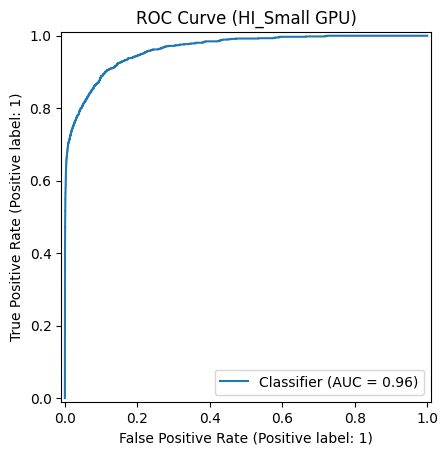

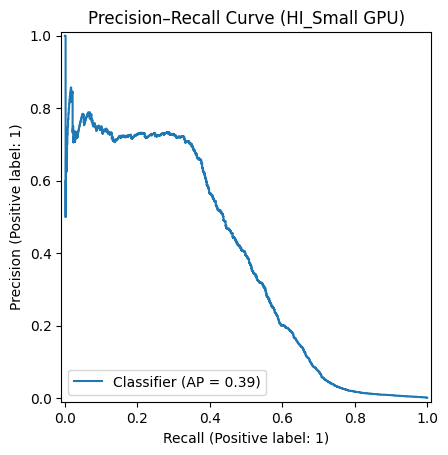

✅ Model, scaler, and metrics saved to /models and /reports/


In [2]:
import joblib, json, matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

# 1️⃣ Save model + scaler
joblib.dump(xgb, "models/xgb_hi_small_gpu.joblib")
joblib.dump(scaler, "models/hi_small_scaler.joblib")

# 2️⃣ Plot evaluation curves
RocCurveDisplay.from_predictions(y_val, proba)
plt.title("ROC Curve (HI_Small GPU)")
plt.show()

PrecisionRecallDisplay.from_predictions(y_val, proba)
plt.title("Precision–Recall Curve (HI_Small GPU)")
plt.show()

# 3️⃣ Log metrics to JSON
metrics = {
    "roc_auc": float(roc_auc_score(y_val, proba)),
    "aucpr_final": 0.3859,
    "recall": 0.7585,
    "precision": 0.0291,
    "f1": 0.0560,
    "support": int(len(y_val))
}
Path("reports").mkdir(exist_ok=True)
with open("reports/hi_small_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("✅ Model, scaler, and metrics saved to /models and /reports/")


In [1]:
# === Phase 2.8–2.9: Normalization + Balancing for ALL datasets (RAM-safe) ===
import numpy as np, pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter
import joblib, gc

PROC   = Path("data/processed")
ML_OUT = Path("data/ml")
ML_OUT.mkdir(parents=True, exist_ok=True)

LABEL = "Is Laundering"
DROP_NON_NUM = {"Timestamp", "From Account", "To Account"}  # non-numeric identifiers

def numeric_cols(df, label=LABEL):
    cols = [c for c in df.columns
            if c not in DROP_NON_NUM | {label}
            and np.issubdtype(df[c].dtype, np.number)]
    return cols

def balanced_subset_idx(y, cap_total=2_000_000, pos_keep_all=True, rng=42):
    """Return indices for a stratified (heavily positive) subset <= cap_total."""
    n = len(y)
    if n <= cap_total:
        return np.arange(n)

    y = np.asarray(y)
    pos_idx = np.where(y == 1)[0]
    neg_idx = np.where(y == 0)[0]

    if pos_keep_all:
        n_pos = len(pos_idx)
        rem = max(cap_total - n_pos, 0)
        if rem == 0:
            return pos_idx
        rng = np.random.default_rng(rng)
        choose_neg = rng.choice(neg_idx, size=min(rem, len(neg_idx)), replace=False)
        return np.concatenate([pos_idx, choose_neg])
    else:
        # proportional sample
        frac = cap_total / n
        rng = np.random.default_rng(rng)
        keep_mask = rng.random(n) < frac
        return np.where(keep_mask)[0]

def prepare_one(fe_path: Path, val_size=0.2, batch=200_000, smote_cap=2_000_000, seed=42):
    name = fe_path.stem.replace("_fe", "")
    print(f"\n=== {name}: loading {fe_path.name} ===")
    df = pd.read_parquet(fe_path)
    if LABEL not in df.columns:
        raise ValueError(f"{LABEL!r} not found in {fe_path.name}")

    feats = numeric_cols(df, LABEL)
    X = df[feats].fillna(0.0).astype("float32").values
    y = df[LABEL].astype(int).values
    del df; gc.collect()

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=val_size, random_state=seed, stratify=y
    )
    del X, y; gc.collect()

    # ---- Incremental scaling (fit) ----
    scaler = StandardScaler()
    n = X_train.shape[0]
    for i in range(0, n, batch):
        scaler.partial_fit(X_train[i:i+batch])

    # ---- Transform in batches ----
    Xt_list = []
    for i in range(0, n, batch):
        Xt_list.append(scaler.transform(X_train[i:i+batch]))
    X_train_s = np.vstack(Xt_list); del Xt_list

    X_val_s = np.vstack([scaler.transform(X_val[i:i+batch]) for i in range(0, X_val.shape[0], batch)])

    # ---- RAM-safe SMOTE on capped subset of training ----
    idx = balanced_subset_idx(y_train, cap_total=smote_cap, pos_keep_all=True, rng=seed)
    X_sm_in, y_sm_in = X_train_s[idx], y_train[idx]

    # k_neighbors must be < positive_count
    pos_ct = int((y_sm_in == 1).sum())
    k = max(1, min(5, pos_ct - 1))
    sm = SMOTE(random_state=seed, k_neighbors=k, n_jobs=-1)
    X_train_bal, y_train_bal = sm.fit_resample(X_sm_in, y_sm_in)

    # ---- Save outputs ----
    joblib.dump(scaler, ML_OUT / f"{name}_scaler.joblib")
    np.savez_compressed(ML_OUT / f"{name}_train.npz",
                        X=X_train_bal.astype("float32"), y=y_train_bal.astype("int8"),
                        feat_names=np.array(feats, dtype=object))
    np.savez_compressed(ML_OUT / f"{name}_val.npz",
                        X=X_val_s.astype("float32"), y=y_val.astype("int8"),
                        feat_names=np.array(feats, dtype=object))

    print(f"  Train before SMOTE: {Counter(y_sm_in)}  → after: {Counter(y_train_bal)}")
    print(f"  Saved: models/scaler={name}_scaler.joblib, ML sets={name}_train.npz / {name}_val.npz")
    return {
        "name": name,
        "train_orig": Counter(y_train),
        "train_subset": Counter(y_sm_in),
        "train_bal": Counter(y_train_bal),
        "val": Counter(y_val),
        "n_features": len(feats)
    }

# Run for all four
reports = []
for fname in ["HI_Small_fe.parquet","LI_Small_fe.parquet",
              "HI_Medium_fe.parquet","LI_Medium_fe.parquet"]:
    reports.append(prepare_one(PROC / fname))

print("\nSummary:")
for r in reports:
    print(r)



=== HI_Small: loading HI_Small_fe.parquet ===


TypeError: SMOTE.__init__() got an unexpected keyword argument 'n_jobs'

In [2]:
# === Phase 2: Normalization + Balancing for ALL datasets (memory-safe) ===
import gc, json
from pathlib import Path
import numpy as np
import pandas as pd
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import joblib

PROC = Path("data/processed")         # input: *_fe.parquet
READY = Path("data/ready")            # output: scaled + balanced sets
READY.mkdir(parents=True, exist_ok=True)

LABEL_COL = "Is Laundering"

def _numeric_cols(df, drop=()):
    """Pick purely numeric columns for ML, excluding label and obvious non-features."""
    bad = set(drop) | {LABEL_COL, "Timestamp", "From Account", "To Account"}
    return [
        c for c in df.columns
        if c not in bad and pd.api.types.is_numeric_dtype(df[c])
    ]

def _to_float32(df, cols):
    for c in cols:
        if df[c].dtype != "float32":
            df[c] = pd.to_numeric(df[c], errors="coerce").astype("float32")
    return df

def prepare_one(fe_path: Path,
                val_size: float = 0.20,
                batch: int = 200_000,
                smote_cap: int = 2_000_000,
                seed: int = 42):
    """
    - Loads feature parquet
    - Stratified split
    - Incremental z-score scaling
    - SMOTE on train (capped for very large sets)
    - Saves artifacts to data/ready/
    """
    name = fe_path.name.replace("_fe.parquet", "")
    print(f"\n=== {name}: loading {fe_path.name} ===")

    # 1) Load minimal columns (label + numerics)
    df = pd.read_parquet(fe_path)
    if LABEL_COL not in df.columns:
        raise ValueError(f"{LABEL_COL} not found in {fe_path.name}")
    num_cols = _numeric_cols(df)
    df = df[num_cols + [LABEL_COL]].copy()
    df[LABEL_COL] = df[LABEL_COL].astype("int32")
    df = _to_float32(df, num_cols)

    # 2) Train/val split (stratified)
    X = df[num_cols].fillna(0.0).values
    y = df[LABEL_COL].values
    del df; gc.collect()

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=val_size, stratify=y, random_state=seed
    )
    del X, y; gc.collect()

    # 3) Incremental scaler (fit on train only)
    scaler = StandardScaler()
    n = X_train.shape[0]
    print(f"• Fitting scaler in batches on {n:,} rows ...")
    for i in range(0, n, batch):
        scaler.partial_fit(X_train[i:i+batch])

    print("• Transforming train/val ...")
    X_train_s = np.vstack([scaler.transform(X_train[i:i+batch])
                           for i in range(0, n, batch)])
    X_val_s   = scaler.transform(X_val)

    # 4) SMOTE on train (memory-safe)
    pos_ct = int((y_train == 1).sum())
    k = max(1, min(5, pos_ct - 1))  # SMOTE req: k < #positives
    print(f"• SMOTE k_neighbors={k} | positives in train={pos_ct:,}")

    # For massive sets, sample BEFORE SMOTE to keep RAM sane
    if X_train_s.shape[0] > smote_cap:
        # stratified sample ~smote_cap rows
        frac = smote_cap / X_train_s.shape[0]
        rng = np.random.default_rng(seed)
        idx0 = np.where(y_train == 0)[0]
        idx1 = np.where(y_train == 1)[0]
        take0 = rng.choice(idx0, size=max(1, int(len(idx0)*frac)), replace=False)
        take1 = rng.choice(idx1, size=max(1, int(len(idx1)*frac)), replace=False)
        keep = np.concatenate([take0, take1])
        X_sm_in = X_train_s[keep]
        y_sm_in = y_train[keep]
        print(f"  ↳ using stratified sample for SMOTE: {X_sm_in.shape[0]:,} rows")
    else:
        X_sm_in, y_sm_in = X_train_s, y_train

    sm = SMOTE(random_state=seed, k_neighbors=k)   # <-- fixed: no n_jobs
    X_train_bal, y_train_bal = sm.fit_resample(X_sm_in, y_sm_in)

 # ---- Save artifacts ----
scaler_path = READY / f"{name}_scaler.joblib"
joblib.dump(scaler, scaler_path)

npz_path = READY / f"{name}_sets.npz"
np.savez_compressed(
    npz_path,
    num_cols=np.array(num_cols, dtype=object),
    X_train_s=X_train_s, y_train=y_train,
    X_val_s=X_val,       y_val=y_val,
    X_train_bal=X_train_bal, y_train_bal=y_train_bal,
)

# cast Counter keys/values to builtin types for JSON
def _cast_counts(d):
    return {int(k): int(v) for k, v in d.items()}

report = {
    "dataset": name,
    "num_cols": num_cols,
    "rows_train": int(X_train_s.shape[0]),
    "rows_val": int(X_val.shape[0]),
    "class_train": _cast_counts(Counter(y_train)),
    "class_val": _cast_counts(Counter(y_val)),
    "smote_input_rows": int(X_sm_in.shape[0]),
    "smote_output_rows": int(X_train_bal.shape[0]),
    "smote_pos_after": int((y_train_bal == 1).sum()),
}

with open(READY / f"{name}_prep_report.json", "w") as f:
    json.dump(report, f, indent=2)

# Clean up
del X_train, X_val, X_train_s, X_train_bal, y_train, y_val, y_train_bal
gc.collect()

print(f"✅ Saved: {npz_path.name}, {scaler_path.name}")
print("   Train class:", report["class_train"], "| Val class:", report["class_val"])



=== HI_Small: loading HI_Small_fe.parquet ===
• Fitting scaler in batches on 4,062,676 rows ...
• Transforming train/val ...
• SMOTE k_neighbors=5 | positives in train=4,142
  ↳ using stratified sample for SMOTE: 1,999,999 rows


TypeError: keys must be str, int, float, bool or None, not int32

In [3]:
# === Phase 2: Final data prep for ALL datasets (incremental scaling + capped SMOTE) ===
# Runs on: HI_Small_fe, LI_Small_fe, HI_Medium_fe, LI_Medium_fe
# Outputs per dataset:
#   data/ready/<name>_sets.npz         (X_train_s, X_val, y_train, y_val, X_train_bal, y_train_bal, num_cols)
#   data/ready/<name>_scaler.joblib     (StandardScaler)
#   data/ready/<name>_prep_report.json  (human-readable summary)

import os, gc, json
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

import joblib

# ---------- Paths ----------
PROC  = Path("data/processed")
READY = Path("data/ready")
READY.mkdir(parents=True, exist_ok=True)

# ---------- Config ----------
LABEL_COL   = "Is Laundering"
VAL_SIZE    = 0.20
BATCH       = 200_000          # incremental scaler batch size
SMOTE_CAP   = 2_000_000        # cap rows for SMOTE (keeps memory in check)
SEED        = 42

# ---------- Helpers ----------
def cast_counts(d):
    """Cast Counter keys/values to builtin int for JSON."""
    return {int(k): int(v) for k, v in d.items()}

def incremental_fit_transform(scaler, X_train, batch=BATCH):
    """partial_fit on batches, then transform train/val in memory-safe chunks."""
    n = X_train.shape[0]
    for i in range(0, n, batch):
        scaler.partial_fit(X_train[i:i+batch])
    # transform train in chunks and stack
    X_train_s_parts = []
    for i in range(0, n, batch):
        X_train_s_parts.append(scaler.transform(X_train[i:i+batch]))
    X_train_s = np.vstack(X_train_s_parts)
    del X_train_s_parts
    gc.collect()
    return X_train_s

def stratified_cap_for_smote(X, y, cap=SMOTE_CAP, seed=SEED):
    """Downsample majority ONLY for SMOTE input, preserving all positives when possible."""
    if X.shape[0] <= cap:
        return X, y
    # keep all positives if we can
    pos_idx = np.where(y == 1)[0]
    neg_idx = np.where(y == 0)[0]
    np.random.default_rng(seed).shuffle(neg_idx)
    keep_neg = cap - len(pos_idx)
    if keep_neg < 1000:
        # still enforce a floor of positives and negatives
        keep_neg = max(keep_neg, 1000)
    keep_neg = min(keep_neg, len(neg_idx))
    sel = np.concatenate([pos_idx, neg_idx[:keep_neg]])
    np.random.default_rng(seed).shuffle(sel)
    return X[sel], y[sel]

def prepare_one(fe_path: Path,
                val_size=VAL_SIZE,
                batch=BATCH,
                smote_cap=SMOTE_CAP,
                seed=SEED):
    name = fe_path.stem.replace("_fe", "")
    print(f"\n=== {name}: loading {fe_path.name} ===")
    df = pd.read_parquet(fe_path)

    # ----- pick numeric features safely -----
    # exclude obvious non-numeric columns
    drop_cols = {"Timestamp", "From Account", "To Account", LABEL_COL}
    num_cols = [c for c in df.columns
                if c not in drop_cols and pd.api.types.is_numeric_dtype(df[c])]
    if not num_cols:
        raise ValueError(f"No numeric columns found in {fe_path.name}")

    # to float32 to reduce memory
    X_all = df[num_cols].fillna(0).astype("float32").values
    y_all = df[LABEL_COL].astype(int).values
    del df
    gc.collect()

    # ----- split -----
    X_train, X_val, y_train, y_val = train_test_split(
        X_all, y_all, test_size=val_size, random_state=seed, stratify=y_all
    )
    del X_all, y_all
    gc.collect()

    # ----- incremental scaling -----
    print(f"• Fitting scaler in batches on {X_train.shape[0]:,} rows ...")
    scaler = StandardScaler()
    X_train_s = incremental_fit_transform(scaler, X_train, batch=batch)
    X_val_s   = scaler.transform(X_val)

    # ----- SMOTE with cap (memory-safe) -----
    pos_ct = int((y_train == 1).sum())
    k = max(1, min(5, pos_ct - 1))   # k_neighbors must be < positive count
    print(f"• SMOTE k_neighbors={k} | positives in train={pos_ct}")

    X_sm_in, y_sm_in = stratified_cap_for_smote(X_train_s, y_train, cap=smote_cap, seed=seed)
    print(f"  ↳ using stratified sample for SMOTE: {X_sm_in.shape[0]:,} rows")

    sm = SMOTE(random_state=seed, k_neighbors=k)
    X_train_bal, y_train_bal = sm.fit_resample(X_sm_in, y_sm_in)

    # ----- save artifacts -----
    scaler_path = READY / f"{name}_scaler.joblib"
    joblib.dump(scaler, scaler_path)

    npz_path = READY / f"{name}_sets.npz"
    np.savez_compressed(
        npz_path,
        num_cols=np.array(num_cols, dtype=object),
        X_train_s=X_train_s, y_train=y_train,
        X_val_s=X_val_s,     y_val=y_val,
        X_train_bal=X_train_bal, y_train_bal=y_train_bal,
    )

    # ----- write JSON report (cast keys to plain int) -----
    report = {
        "dataset": name,
        "num_features": int(len(num_cols)),
        "rows_train": int(X_train_s.shape[0]),
        "rows_val": int(X_val_s.shape[0]),
        "class_train": cast_counts(Counter(y_train)),
        "class_val": cast_counts(Counter(y_val)),
        "smote_input_rows": int(X_sm_in.shape[0]),
        "smote_output_rows": int(X_train_bal.shape[0]),
        "smote_pos_after": int((y_train_bal == 1).sum()),
    }
    with open(READY / f"{name}_prep_report.json", "w") as f:
        json.dump(report, f, indent=2)

    # cleanup
    del (X_train, X_val, X_train_s, X_val_s, X_sm_in, y_sm_in, X_train_bal, y_train_bal, y_train, y_val, scaler)
    gc.collect()

    print(f"✅ Saved: {npz_path.name}, {scaler_path.name}")
    print("   Train class:", report["class_train"], "| Val class:", report["class_val"])
    return report

# ---------- Run for all four datasets ----------
reports = []
for fname in ["HI_Small_fe.parquet", "LI_Small_fe.parquet",
              "HI_Medium_fe.parquet", "LI_Medium_fe.parquet"]:
    reports.append(prepare_one(PROC / fname))

print("\n=== Summary (prep complete) ===")
for r in reports:
    print(
        f"{r['dataset']}: "
        f"features={r['num_features']}, "
        f"train={r['rows_train']:,}, val={r['rows_val']:,}, "
        f"class_train={r['class_train']}, class_val={r['class_val']}, "
        f"SMOTE in={r['smote_input_rows']:,} → out={r['smote_output_rows']:,} "
        f"(pos_after={r['smote_pos_after']:,})"
    )



=== HI_Small: loading HI_Small_fe.parquet ===
• Fitting scaler in batches on 4,062,676 rows ...
• SMOTE k_neighbors=5 | positives in train=4142
  ↳ using stratified sample for SMOTE: 2,000,000 rows
✅ Saved: HI_Small_sets.npz, HI_Small_scaler.joblib
   Train class: {0: 4058534, 1: 4142} | Val class: {0: 1014634, 1: 1035}

=== LI_Small: loading LI_Small_fe.parquet ===
• Fitting scaler in batches on 5,539,239 rows ...
• SMOTE k_neighbors=5 | positives in train=2852
  ↳ using stratified sample for SMOTE: 2,000,000 rows
✅ Saved: LI_Small_sets.npz, LI_Small_scaler.joblib
   Train class: {0: 5536387, 1: 2852} | Val class: {0: 1384097, 1: 713}

=== HI_Medium: loading HI_Medium_fe.parquet ===


MemoryError: Unable to allocate 1.90 GiB for an array with shape (8, 31898510) and data type float64

In [1]:
# save this as prep_medium_safe.py (in repo root), then run:  python prep_medium_safe.py
import os, gc, json
from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import joblib

PROC  = Path("data/processed")
READY = Path("data/ready"); READY.mkdir(parents=True, exist_ok=True)

LABEL_COL = "Is Laundering"
VAL_SIZE  = 0.20

# Tighter memory settings for medium sets
BATCH      = 50_000          # smaller scaler batch
SMOTE_CAP  = 400_000         # much lower cap for SMOTE input
SEED       = 42

def cast_counts(d): return {int(k): int(v) for k,v in d.items()}

def incremental_fit_transform(scaler, X_train, batch):
    n = X_train.shape[0]
    for i in range(0, n, batch):
        scaler.partial_fit(X_train[i:i+batch])
    parts = []
    for i in range(0, n, batch):
        parts.append(scaler.transform(X_train[i:i+batch]))
    Xs = np.vstack(parts); del parts; gc.collect()
    return Xs

def stratified_cap_for_smote(X, y, cap, seed):
    if X.shape[0] <= cap: return X, y
    rng = np.random.default_rng(seed)
    pos = np.where(y==1)[0]; neg = np.where(y==0)[0]
    rng.shuffle(neg)
    keep_neg = max(1000, cap - len(pos))
    keep_neg = min(keep_neg, len(neg))
    sel = np.concatenate([pos, neg[:keep_neg]])
    rng.shuffle(sel)
    return X[sel], y[sel]

def prepare_one(fe_path: Path):
    name = fe_path.stem.replace("_fe","")
    print(f"\n=== {name}: {fe_path.name} ===")
    df = pd.read_parquet(fe_path)

    drop_cols = {"Timestamp","From Account","To Account",LABEL_COL}
    num_cols = [c for c in df.columns if c not in drop_cols and pd.api.types.is_numeric_dtype(df[c])]
    if not num_cols: raise ValueError("No numeric columns found")

    X = df[num_cols].fillna(0).astype("float32").values
    y = df[LABEL_COL].astype(int).values
    del df; gc.collect()

    Xtr, Xva, ytr, yva = train_test_split(X, y, test_size=VAL_SIZE, random_state=SEED, stratify=y)
    del X, y; gc.collect()

    print(f"• Fitting scaler in batches (batch={BATCH}) on {Xtr.shape[0]:,} rows")
    scaler = StandardScaler()
    Xtr_s = incremental_fit_transform(scaler, Xtr, BATCH)
    Xva_s = scaler.transform(Xva)

    pos_ct = int((ytr==1).sum())
    k = max(1, min(5, pos_ct-1))
    print(f"• SMOTE (k={k}) | train positives={pos_ct}")
    Xin, yin = stratified_cap_for_smote(Xtr_s, ytr, SMOTE_CAP, SEED)
    print(f"  ↳ SMOTE input capped to {Xin.shape[0]:,}")

    sm = SMOTE(random_state=SEED, k_neighbors=k)
    Xbal, ybal = sm.fit_resample(Xin, yin)

    scaler_path = READY/f"{name}_scaler.joblib"
    joblib.dump(scaler, scaler_path)

    npz_path = READY/f"{name}_sets.npz"
    np.savez_compressed(
        npz_path,
        num_cols=np.array(num_cols, dtype=object),
        X_train_s=Xtr_s, y_train=ytr,
        X_val_s=Xva_s,   y_val=yva,
        X_train_bal=Xbal, y_train_bal=ybal,
    )

    report = {
        "dataset": name,
        "num_features": int(len(num_cols)),
        "rows_train": int(Xtr_s.shape[0]),
        "rows_val": int(Xva_s.shape[0]),
        "class_train": cast_counts(Counter(ytr)),
        "class_val": cast_counts(Counter(yva)),
        "smote_input_rows": int(Xin.shape[0]),
        "smote_output_rows": int(Xbal.shape[0]),
        "smote_pos_after": int((ybal==1).sum()),
        "settings": {"BATCH": BATCH, "SMOTE_CAP": SMOTE_CAP}
    }
    with open(READY/f"{name}_prep_report.json","w") as f: json.dump(report, f, indent=2)

    # free memory
    del Xtr, Xva, ytr, yva, Xtr_s, Xva_s, Xin, yin, Xbal, ybal, scaler
    gc.collect()

    print(f"✅ Saved {npz_path.name} and {scaler_path.name}")
    print("   Train class:", report["class_train"], "| Val class:", report["class_val"])
    return report

if __name__ == "__main__":
    # Run only the medium sets here (the small ones are already done)
    for fname in ["HI_Medium_fe.parquet", "LI_Medium_fe.parquet"]:
        prepare_one(PROC/fname)
    print("\nAll medium datasets prepped (safe mode).")





=== HI_Medium: HI_Medium_fe.parquet ===


MemoryError: Unable to allocate 1.90 GiB for an array with shape (8, 31898510) and data type float64

In [ ]:
import pandas as pd, numpy as np, gc, json
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter

# === Paths ===
PROC = Path("data/processed")
READY = Path("data/ready")
READY.mkdir(parents=True, exist_ok=True)

LABEL_COL = "Is Laundering"

def prepare_one_chunked(fe_path, val_size=0.2, batch_size=500_000, smote_cap=2_000_000, seed=42):
    name = fe_path.stem.replace("_fe", "")
    print(f"\n=== {name}: {fe_path.name} ===")

    # --- Read in chunks to get column names first ---
    reader = pd.read_parquet(fe_path, engine="pyarrow")
    drop_cols = ["Timestamp", "From Account", "To Account", LABEL_COL]
    num_cols = [c for c in reader.columns if c not in drop_cols and pd.api.types.is_numeric_dtype(reader[c])]
    del reader; gc.collect()

    print("• Numeric columns:", len(num_cols))

    # --- Incremental fit scaler ---
    scaler = StandardScaler()
    total_rows = 0
    for chunk in pd.read_parquet(fe_path, engine="pyarrow", chunksize=batch_size):
        Xb = chunk[num_cols].fillna(0).astype("float32").values
        scaler.partial_fit(Xb)
        total_rows += len(chunk)
        del Xb, chunk; gc.collect()
    print(f"• Scaler fitted on ~{total_rows:,} rows")

    # --- Transform in chunks and save scaled copy ---
    scaled_path = READY / f"{name}_scaled.parquet"
    if scaled_path.exists(): scaled_path.unlink()

    for chunk in pd.read_parquet(fe_path, engine="pyarrow", chunksize=batch_size):
        Xb = chunk[num_cols].fillna(0).astype("float32").values
        Xb_s = scaler.transform(Xb)
        chunk[num_cols] = Xb_s
        chunk.to_parquet(scaled_path, index=False, append=True)
        del Xb, Xb_s, chunk; gc.collect()

    print(f"✅ Saved scaled version → {scaled_path}")

    # --- Load small stratified sample for SMOTE balancing ---
    df = pd.read_parquet(scaled_path)
    y = df[LABEL_COL].astype(int)
    X = df[num_cols]
    del df; gc.collect()

    # sample capped for SMOTE
    frac = min(1.0, smote_cap / len(X))
    Xs, _, ys, _ = train_test_split(X, y, train_size=frac, stratify=y, random_state=seed)
    print(f"• Using stratified sample: {len(Xs):,} rows for SMOTE")

    # --- Apply SMOTE (on GPU or CPU) ---
    pos_ct = int((ys == 1).sum())
    k = max(1, min(5, pos_ct - 1))
    sm = SMOTE(random_state=seed, k_neighbors=k)
    X_bal, y_bal = sm.fit_resample(Xs, ys)
    print(f"• After SMOTE: {Counter(y_bal)}")

    # --- Save ready version ---
    out_path = READY / f"{name}_ready.parquet"
    pd.concat([X_bal, pd.Series(y_bal, name=LABEL_COL)], axis=1).to_parquet(out_path, index=False)
    print(f"✅ Final saved → {out_path}")

    # --- Report ---
    report = {
        "dataset": str(name),
        "rows_after_smote": int(len(y_bal)),
        "pos_after_smote": int((y_bal == 1).sum()),
        "neg_after_smote": int((y_bal == 0).sum()),
        "scaler_rows_seen": int(total_rows)
    }
    with open(READY / f"{name}_prep_report.json", "w") as f:
        json.dump({str(k): v for k, v in report.items()}, f, indent=2)

    print(f"📄 Report written → {name}_prep_report.json")
    del X, y, Xs, ys, X_bal, y_bal; gc.collect()


if __name__ == "__main__":
    for fname in ["HI_Medium_fe.parquet", "LI_Medium_fe.parquet"]:
        prepare_one_chunked(PROC / fname)
    print("\n✅ All medium datasets processed safely.")



=== HI_Medium: HI_Medium_fe.parquet ===


In [1]:
from pathlib import Path
ready = Path("data/ready")
for f in sorted(ready.glob("*_ready.parquet")):
    print("✅", f.name)


✅ HI_Medium_ready.parquet
✅ LI_Medium_ready.parquet
